# Preliminaries

* **Imports**
* **Data Loading**

In [1]:
# general tools
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#sns.set_style("dark")
#sns.set_context("paper")

# preprocessing
import scipy.cluster.hierarchy as sch

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import svm, metrics, preprocessing

from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import get_variable_name

In [2]:
# data imports

### EDIT FILEPATH IF NECESSARY
root = '.'
data_dir = '/DataFiles/'

# form filepaths
data_path = root + data_dir
train_file = data_path + 'CreditCard_train.csv'
test_file = data_path + 'CreditCard_test.csv'

# load
_df_train = pd.read_csv(train_file, index_col=0, header=1).rename(columns={'PAY_0':'PAY_1', 'default payment next month':'DEFAULT'})
_df_test = pd.read_csv(test_file, index_col=0, header=1).rename(columns={'PAY_0':'PAY_1', 'default payment next month':'DEFAULT'})

In [3]:
print(train_file)

./DataFiles/CreditCard_train.csv


# Data Cleaning & EDA


## Data Cleaning

To be cleaned:
* `AGE`: Creation of 'bins'
* `EDUCATION`: Grouping categories `4,5,6,0`
* `PAY_n`: Categorical/One-Hot Encoding
* `SEX`: Categorical/One-Hot Encoding
* `MARRIAGE`: Grouping categories `0` and `3`

In [4]:
# create copy df for handling
df_train = _df_train.copy()
df_test = _df_test.copy()

In [5]:
# this dataset can be changed for whatever after feature selection

# split X, y
X_train, y_train = df_train.iloc[:,:-1], df_train.iloc[:,-1:] #not necessary yet
X_test, y_test = df_test.iloc[:,:-1], df_test.iloc[:,-1:]

# reshape y into 1d column vector
y_train, y_test = np.reshape(y_train, (y_train.shape[0],)), np.reshape(y_test, (y_test.shape[0],))

X_train = preprocessing.scale(X_train)
# y_train = preprocessing.scale(y_train)

X_test = preprocessing.scale(X_test)
# y_test = preprocessing.scale(y_test)


# # unravel labels for SVM
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

### Cleaning Vars

#### Age

In [6]:
# inspect
_df_train.AGE.describe()

count    24000.000000
mean        35.380458
std          9.271050
min         21.000000
25%         28.000000
50%         34.000000
75%         41.000000
max         79.000000
Name: AGE, dtype: float64

In [7]:
# create bins for 'AGE'
df_train['AGE_BIN'] = pd.cut(df_train.AGE,
                              bins=[20,40,60,100],
                              labels=[1,2,3])

# drop 'AGE'
df_train.drop(['AGE'], axis=1, inplace=True)

# inspect
df_train.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT,AGE_BIN
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,2,2,-1,-1,-2,-2,...,0,0,0,689,0,0,0,0,1,1
2,120000,2,2,2,-1,2,0,0,0,2,...,3455,3261,0,1000,1000,1000,0,2000,1,1
3,90000,2,2,2,0,0,0,0,0,0,...,14948,15549,1518,1500,1000,1000,1000,5000,0,1
4,50000,2,2,1,0,0,0,0,0,0,...,28959,29547,2000,2019,1200,1100,1069,1000,0,1
5,50000,1,2,1,-1,0,-1,0,0,0,...,19146,19131,2000,36681,10000,9000,689,679,0,2


#### Education

In [8]:
# inspect
_df_train.EDUCATION.value_counts()

2    11360
1     8443
3     3850
5      207
4       92
6       37
0       11
Name: EDUCATION, dtype: int64

In [9]:
# Group 4,5,6,0 categories for 'EDUCATION'
ed_map = {1:1, 2:2, 3:3, 4:4, 5:4, 6:4, 0:4}
df_train.EDUCATION = df_train.EDUCATION.map(ed_map)

# inspect
df_train.EDUCATION.value_counts()

2    11360
1     8443
3     3850
4      347
Name: EDUCATION, dtype: int64

#### Marriage

In [10]:
# inspect
_df_train.MARRIAGE.value_counts()

2    12877
1    10813
3      269
0       41
Name: MARRIAGE, dtype: int64

In [11]:
# Group 0, 3 categories for 'MARRIAGE'
marr_map = {0:0, 1:1, 2:2, 3:0}
df_train.MARRIAGE = df_train.MARRIAGE.map(marr_map)

# inspect
df_train.MARRIAGE.value_counts()

2    12877
1    10813
0      310
Name: MARRIAGE, dtype: int64

### Encoding Categoricals

Need to encode:
* `AGE`
* `EDUCATION`
* `SEX`
* `MARRIAGE`

Note that we leave `PAY_n` unencoded because it is semi-continuous (i.e. the increase in the figure corresponds to an increase in months outstanding for payment).

In [12]:
# encoding categoricals
categoricals = ['SEX', 'EDUCATION', 'MARRIAGE', 'AGE_BIN']
for col in categoricals: 
    df_train[col] = df_train[col].astype('category')

# create dummy cols, join, and drop old
cat_df = df_train[categoricals]
cat_df = pd.get_dummies(cat_df)
df_train = df_train.join(cat_df).drop(categoricals, axis=1)

# inspect
df_train.head()

,LIMIT_BAL,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,...,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,AGE_BIN_1,AGE_BIN_2,AGE_BIN_3
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,-1,-1,-2,-2,3913,3102,689,...,0,1,0,0,0,1,0,1,0,0
2,120000,-1,2,0,0,0,2,2682,1725,2682,...,0,1,0,0,0,0,1,1,0,0
3,90000,0,0,0,0,0,0,29239,14027,13559,...,0,1,0,0,0,0,1,1,0,0
4,50000,0,0,0,0,0,0,46990,48233,49291,...,0,1,0,0,0,1,0,1,0,0
5,50000,-1,0,-1,0,0,0,8617,5670,35835,...,0,1,0,0,0,1,0,0,1,0


## EDA

### Distributions

In [13]:
# set up graphic
def plot_hist(df, features, num_r, num_c):
    
    # set up graphics
    fig, axs = plt.subplots(6, 2, figsize=(16, 24), sharex=False, sharey=False)
    colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:pink', 'tab:olive', 'tab:orange']

    # plot grid
    for i in range(num_r):
        feature = features[i]
        for j in range(num_c):
            if j == 1:
                scaler = StandardScaler()
                x = scaler.fit_transform(df[feature].values.reshape(-1,1)) # standardize second row
                title = feature + ' (Standardized)'
            else: 
                x = df[feature]
                title = feature + ' (Unstandardized)'
            ax = sns.distplot(x, hist=True, kde=False, ax=axs[i, j])
            ax.set(xlabel=None, ylabel="Counts")
            ax.set_title(title, fontweight='bold')

    # display
    plt.subplots_adjust(hspace=0.4)
    plt.suptitle('THIS IS THE TITLE', y=0.90, fontsize='x-large', fontweight='bold')

/Users/Jurren/Library/Python/3.8/lib/python/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/Jurren/Library/Python/3.8/lib/python/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/Jurren/Library/Python/3.8/lib/python/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with si

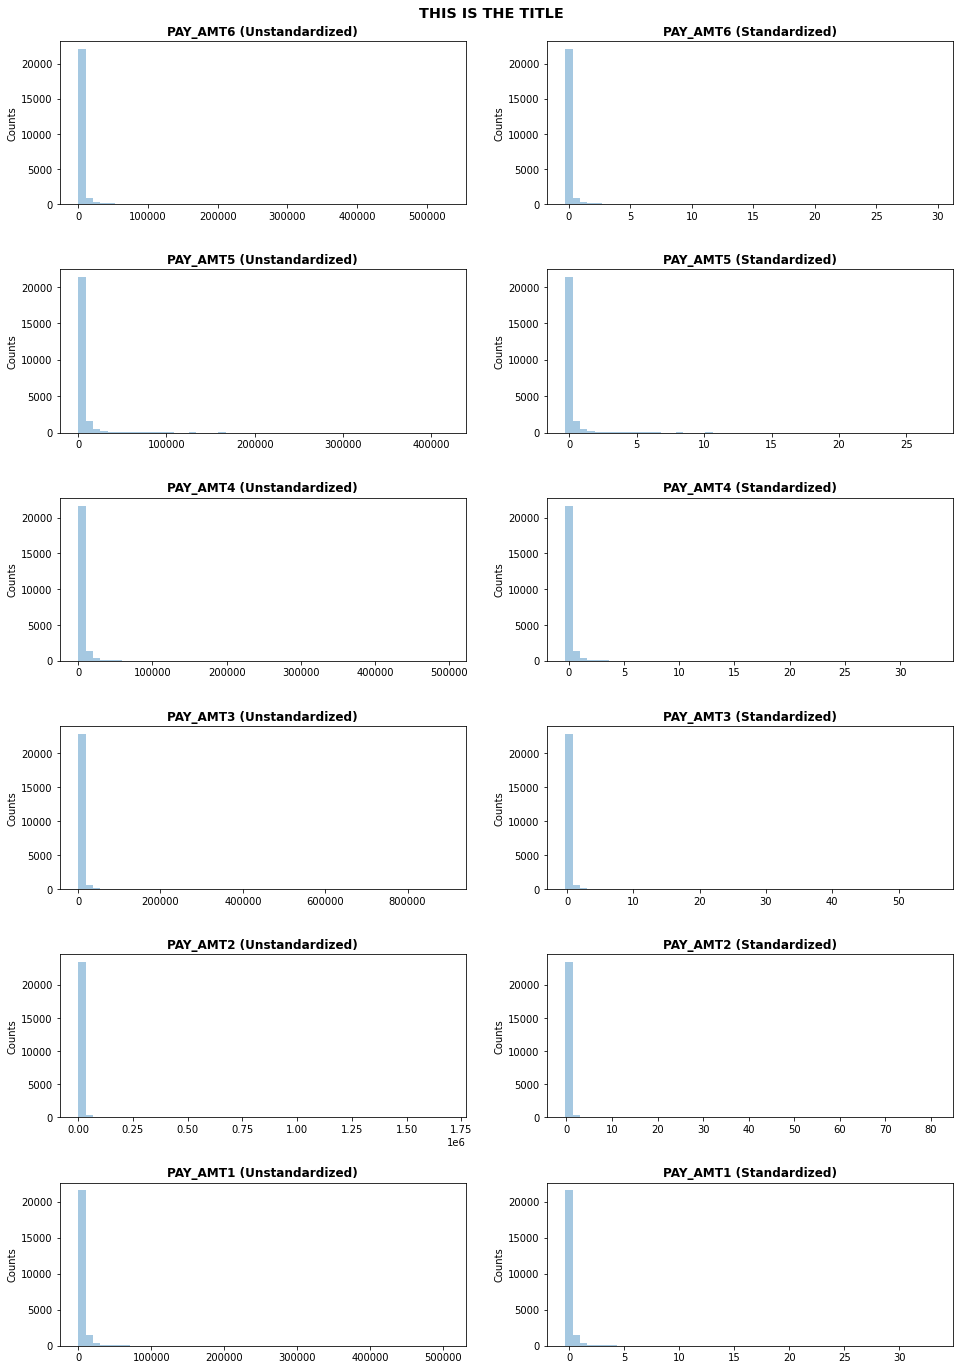

In [14]:
# distributions for 'PAY_AMT'
pay_amt_features = ['PAY_AMT6', 'PAY_AMT5', 'PAY_AMT4', 'PAY_AMT3', 'PAY_AMT2', 'PAY_AMT1']
plot_hist(df_train, pay_amt_features, 6, 2)

/Users/Jurren/Library/Python/3.8/lib/python/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/Jurren/Library/Python/3.8/lib/python/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/Jurren/Library/Python/3.8/lib/python/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with si

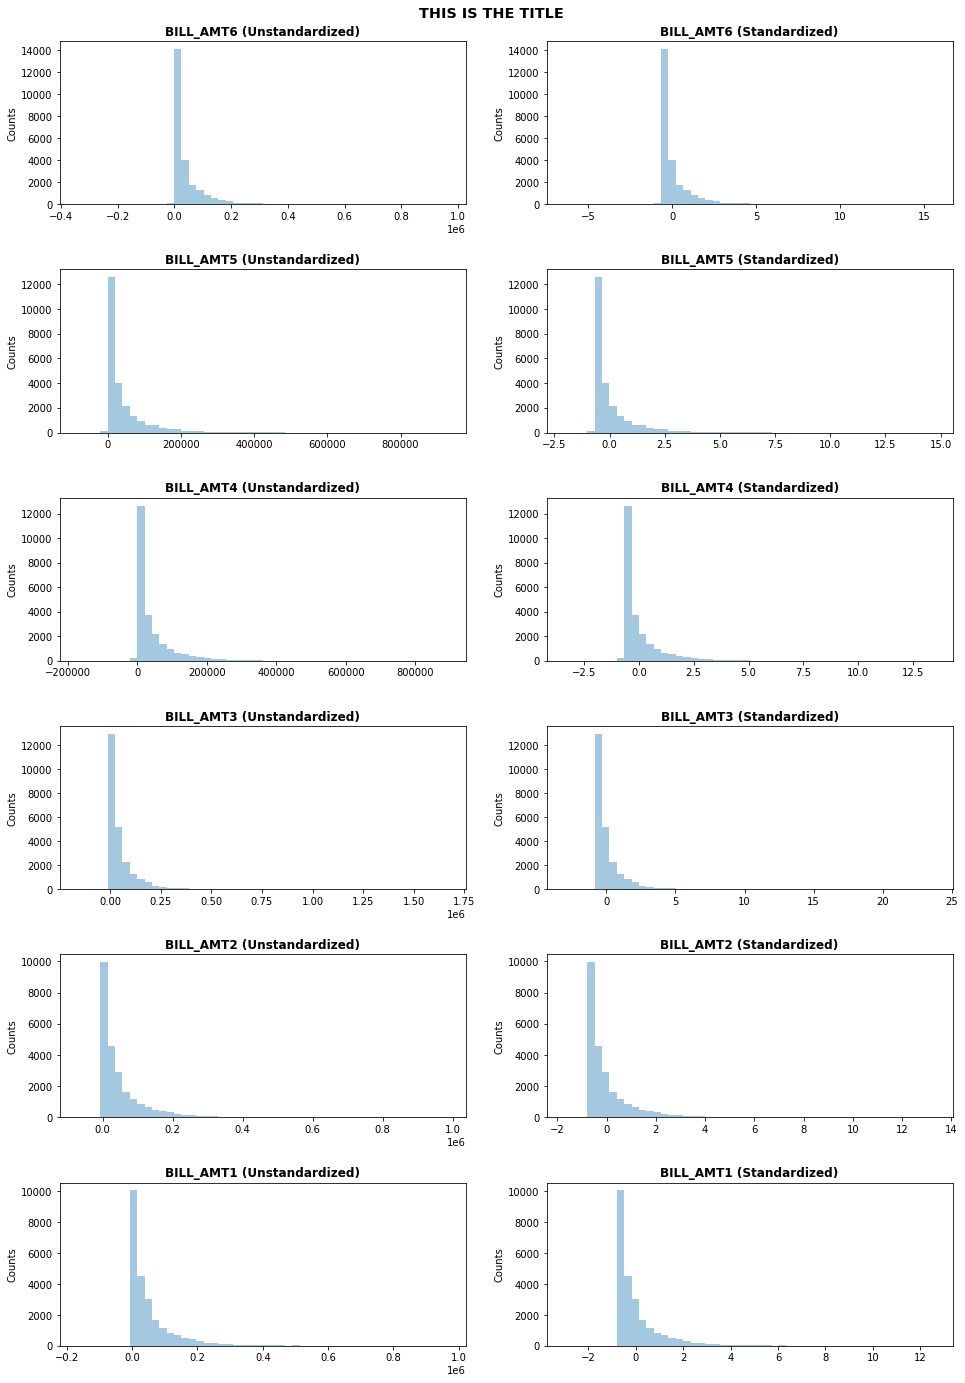

In [15]:
# distributions for 'BILL_AMT'
pay_amt_features = ['BILL_AMT6', 'BILL_AMT5', 'BILL_AMT4', 'BILL_AMT3', 'BILL_AMT2', 'BILL_AMT1']
plot_hist(df_train, pay_amt_features, 6, 2)

### Correlations

First, we try to visualize the correlations of the data, and include a weighting of the correlations between features and the target variable.

In [16]:
# define features
cols = df_train.columns.values
to_drop = ['DEFAULT']
features = np.setdiff1d(cols, to_drop)

# inspect
features

array(['AGE_BIN_1', 'AGE_BIN_2', 'AGE_BIN_3', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'EDUCATION_1',
       'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4', 'LIMIT_BAL',
       'MARRIAGE_0', 'MARRIAGE_1', 'MARRIAGE_2', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'PAY_AMT1', 'PAY_AMT2',
       'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'SEX_1', 'SEX_2'],
      dtype=object)

In [17]:
# compute feature correlation matrix
df_features = df_train[features]
df_feature_corr = df_features.corr()
corr_matrix = np.asmatrix(df_feature_corr)

# compute feature correlations with target
target_corr = df_train.corr().loc['DEFAULT', df_train.corr().columns.difference(['DEFAULT'])].to_numpy()

In [18]:
# Creates graph using the data from the correlation matrix
G = nx.from_numpy_matrix(corr_matrix)

# relabels nodes to match features
G = nx.relabel_nodes(G, lambda x: features[x])

In [19]:
def create_corr_network(G, corr_dir, min_corr, sizes):
    '''
    Plots a circular correlation network between all features. The weight
    of the edges corresponds to the correlation between two features.
    The size of the nodes corresponds to another desired arbitrary indicator.
    
    Args:
        G (NetworkX Graph Object): Graph.
        corr_dir (String): Direction of the correlations to examine
                          (positive or negative).
        min_corr (Float): Minimum correlation for edge to be displayed.
        sizes (List of Floats): Size of each node in the network. 
        
    Returns:
        None
    '''
    
    # creates a copy of the graph
    H = G.copy()
    
    # checks all edges and removes some based on corr_dir, and min_corr
    for feat_1, feat_2, weight in G.edges(data=True):
        if corr_dir == 'positive':
            if weight['weight'] < 0 or abs(weight['weight']) < min_corr:
                H.remove_edge(feat_1, feat_2)
        else:
            if weight['weight'] >= 0 or abs(weight['weight']) < min_corr:
                H.remove_edge(feat_1, feat_2)
                
    # create list for the edges and for the weights
    edges, weights = zip(*nx.get_edge_attributes(H,'weight').items())
    
    # increase weight values to make vals more distinct 
    weights = tuple([(1 + abs(x))**2 for x in weights])
    
    # calculates degree of each node
    nodelist, node_sizes = zip(*nx.degree(H))
    
    # positions
    positions = nx.circular_layout(H)
    
    # fig size
    plt.figure(figsize=(15,15))
    
    # draws nodes
    nx.draw_networkx_nodes(H, 
                           positions, 
                           node_color='#DA70D6',
                           nodelist=nodelist,
                           node_size=[abs(x)*5000 for x in sizes], 
                           alpha=0.8)
    
    # styling for labels
    nx.draw_networkx_labels(H, 
                            positions, 
                            font_size=8,
                            font_family='sans-serif')
    
    # color setting
    if corr_dir == 'positive':
        main_color = plt.cm.GnBu
    else:
        main_color = plt.cm.PuRd
    
    # draws the edges
    nx.draw_networkx_edges(H, 
                           positions, 
                           edgelist=edges, 
                           style='solid',
                           width=weights,
                           edge_color=weights,
                           edge_cmap=main_color,
                           edge_vmin=min(weights),
                           edge_vmax=max(weights))
    
    # displays the graph without axis
    plt.axis('off')

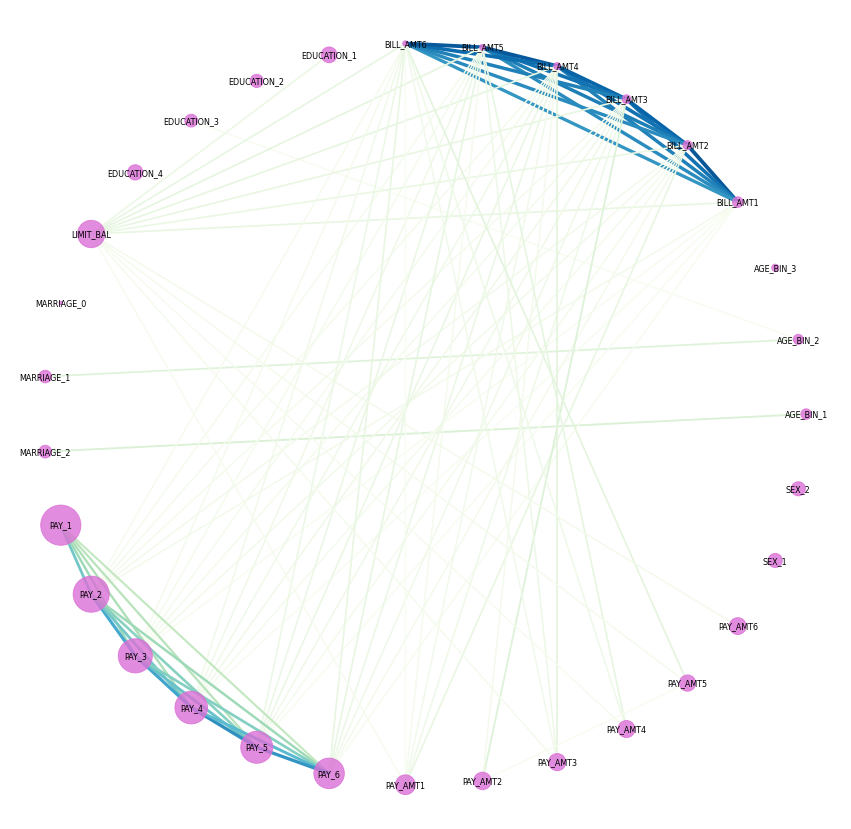

In [20]:
# Plot positive corr network for corrs. > 0.2, 
# assigning each node a size according to its correlation with the
# target variable
create_corr_network(G, 'positive', 0.2, target_corr)

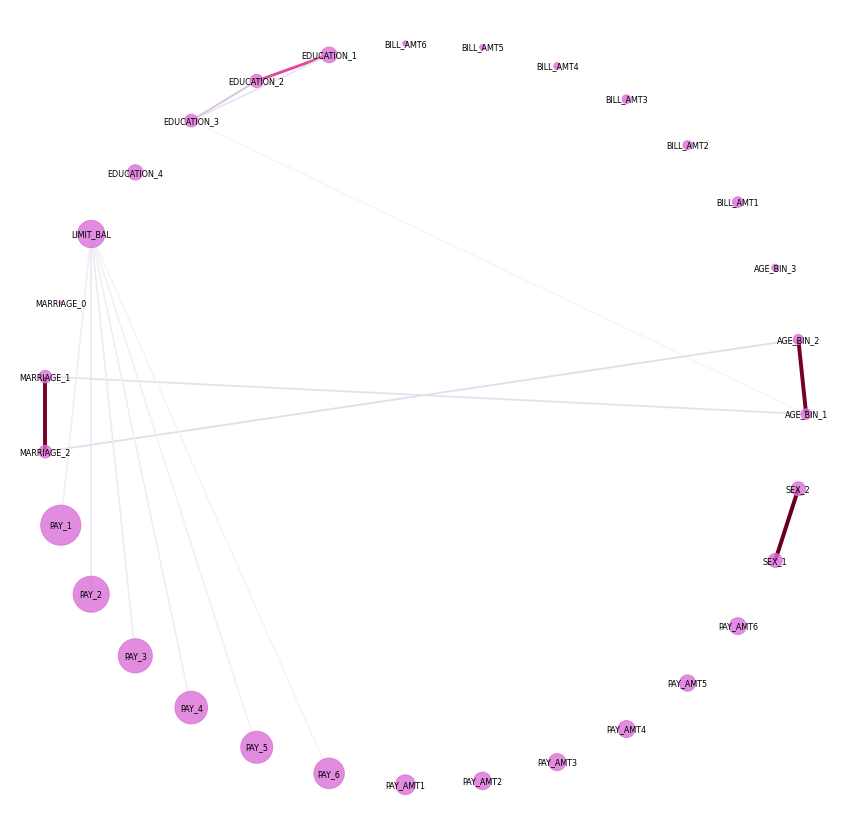

In [21]:
# Plot negative corr network for corrs. > 0.2, 
# assigning each node a size according to its correlation with the
# target variable
create_corr_network(G, 'negative', 0.2, target_corr)

# Oversampling

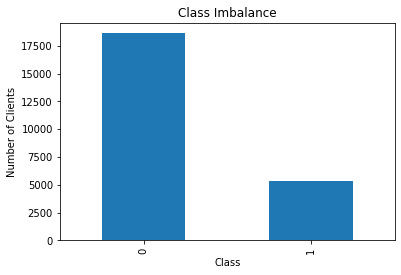

In [22]:
# plot class imbalance
pd.value_counts(df_train['DEFAULT']).plot.bar()
plt.title('Class Imbalance')
plt.xlabel("Class")
plt.ylabel("Number of Clients")
plt.show()

In [23]:
# set data
X = df_features
y = df_train['DEFAULT']

# simple oversampling with SMOTE
smote = SMOTE(random_state=42)
df_train_smote, df_train_smote['DEFAULT'] = smote.fit_resample(X, y)

# hybrid resampling SMOTETomek
smt = SMOTETomek(random_state=42)
df_train_smt, df_train_smt['DEFAULT'] = smt.fit_resample(X, y)

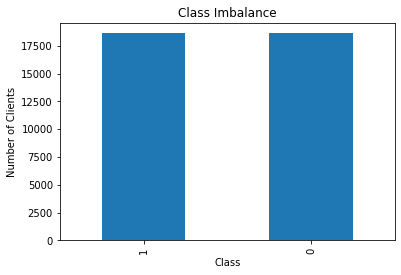

In [24]:
# plot results with SMOTE
pd.value_counts(df_train_smote['DEFAULT']).plot.bar()
plt.title('Class Imbalance')
plt.xlabel("Class")
plt.ylabel("Number of Clients")
plt.show()

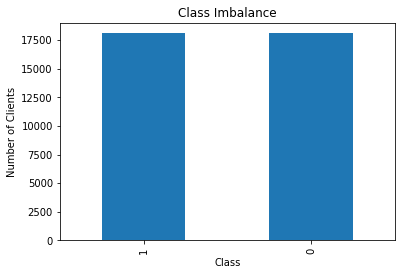

In [25]:
# plot results with SMOTETomek
pd.value_counts(df_train_smt['DEFAULT']).plot.bar()
plt.title('Class Imbalance')
plt.xlabel("Class")
plt.ylabel("Number of Clients")
plt.show()

In [26]:
# we select the SMOTE-Tomek data to move forward
df_train = df_train_smt.copy()
y_train = df_train_smt['DEFAULT']

# Feature Engineering

**TO-DO**:
1. Timeseries Analysis for:
    1. PAY
    2. PAY_AMT (Not necessary)
    3. BILL_AMT (Not necessary)
2. Encoding Domain Expertise:
    1. ?
    2. ?
    3. ?

## Timeseries Analysis: K-Means


### PAY

In [27]:
# select data
pay_features = ['PAY_6', 'PAY_5', 'PAY_4', 'PAY_3', 'PAY_2', 'PAY_1']
df_pay = df_train[pay_features]

# inspect
df_pay.head()

,PAY_6,PAY_5,PAY_4,PAY_3,PAY_2,PAY_1
0,-2,-2,-1,-1,2,2
1,2,0,0,0,2,-1
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,-1,0,-1


In [28]:
# helper: visualize cluster results
def plot_average(centroids, title, labels):
    plt.title(title)
    plt.xticks(range(len(labels)), labels)
    for c in centroids:
        plt.plot(c)

In [29]:
# try different cluster sizes
n_clusters = [3, 4, 5, 6]
_kmeans_pay = {}

for n in n_clusters:
    _kmeans_pay[n] = KMeans(n_clusters=n, random_state=42).fit(df_pay)

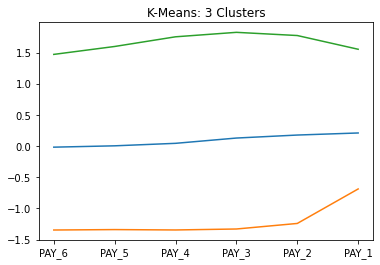

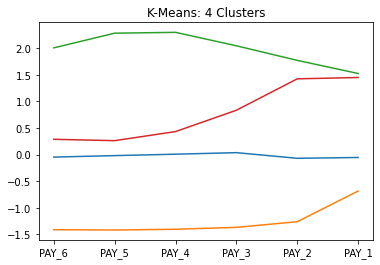

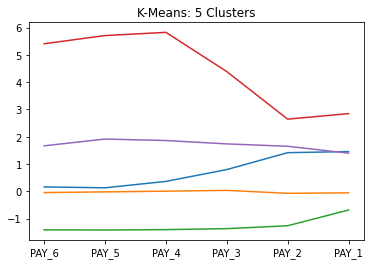

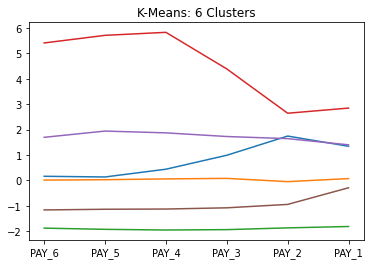

In [30]:
for key, item in _kmeans_pay.items():
    plot_average(item.cluster_centers_, 'K-Means: {} Clusters'.format(key), pay_features)
    plt.show()

I would venture 3-4 clusters is enough. 3 clusters gives a very clear picture of what's going on. However, it is interesting to note that in the case of 4 clusters there is a group that dramatically reduces their payment delay while the other increases it. These could be good signals.

In [31]:
# encode clusters in data
pay_clusters = _kmeans_pay[4].labels_
df_pay_clusters = pd.DataFrame({'PAY_CLUSTER':pay_clusters})
df_pay_clusters['PAY_CLUSTER'] = df_pay_clusters['PAY_CLUSTER'].astype('category')

# one-hot encode
cat_df_pc = pd.get_dummies(df_pay_clusters)

# join with df_train
df_train = df_train.join(cat_df_pc)

# inspect
df_train.head()

,AGE_BIN_1,AGE_BIN_2,AGE_BIN_3,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,EDUCATION_1,...,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_1,SEX_2,DEFAULT,PAY_CLUSTER_0,PAY_CLUSTER_1,PAY_CLUSTER_2,PAY_CLUSTER_3
0,1,0,0,3913,3102,689,0,0,0,0,...,0,0,0,0,1,1,0,0,0,1
1,1,0,0,2682,1725,2682,3272,3455,3261,0,...,1000,0,2000,0,1,1,1,0,0,0
2,1,0,0,29239,14027,13559,14331,14948,15549,0,...,1000,1000,5000,0,1,0,1,0,0,0
3,1,0,0,46990,48233,49291,28314,28959,29547,0,...,1100,1069,1000,0,1,0,1,0,0,0
4,0,1,0,8617,5670,35835,20940,19146,19131,0,...,9000,689,679,1,0,0,1,0,0,0


### PAY_AMT

In [32]:
# select data
pay_amt_features = ['PAY_AMT6', 'PAY_AMT5', 'PAY_AMT4', 'PAY_AMT3', 'PAY_AMT2', 'PAY_AMT1']
df_pay_amt = df_train[pay_amt_features]

# inspect
df_pay_amt.head()

,PAY_AMT6,PAY_AMT5,PAY_AMT4,PAY_AMT3,PAY_AMT2,PAY_AMT1
0,0,0,0,0,689,0
1,2000,0,1000,1000,1000,0
2,5000,1000,1000,1000,1500,1518
3,1000,1069,1100,1200,2019,2000
4,679,689,9000,10000,36681,2000


In [33]:
# try different cluster sizes
n_clusters = [3, 4, 5, 6]
_kmeans_pay_amt = {}

for n in n_clusters:
    _kmeans_pay_amt[n] = KMeans(n_clusters=n, random_state=42).fit(df_pay_amt)

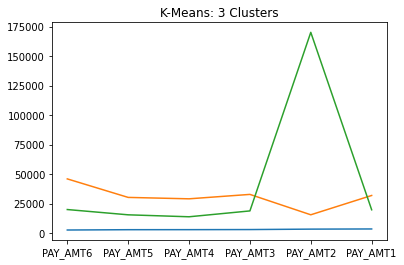

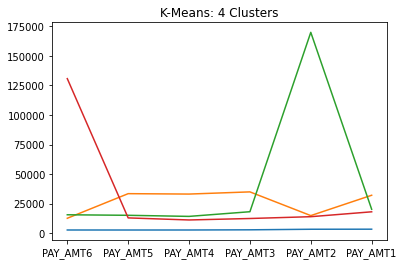

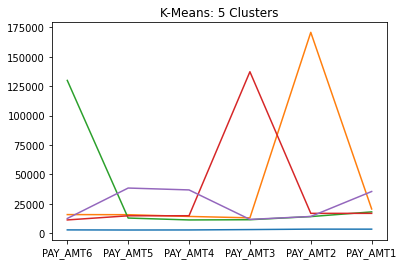

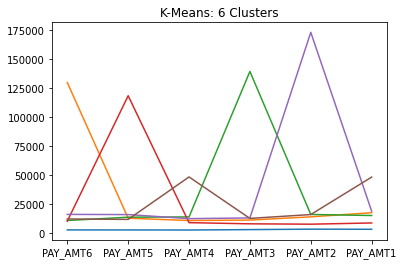

In [34]:
# visualize centroid results
for key, item in _kmeans_pay_amt.items():
    plot_average(item.cluster_centers_, 'K-Means: {} Clusters'.format(key), pay_amt_features)
    plt.show()

In this case, I think 4 clusters is more than enough. While 3 is nice, I think the final 'surge' in payment that can be visualized in the red trace is very interesting.

In [35]:
# encode clusters in data
pay_amt_clusters = _kmeans_pay_amt[3].labels_
df_pay_amt_clusters = pd.DataFrame({'PAY_AMT_CLUSTER':pay_amt_clusters})
df_pay_amt_clusters['PAY_AMT_CLUSTER'] = df_pay_amt_clusters['PAY_AMT_CLUSTER'].astype('category')

# one-hot encode
cat_df_pamtc = pd.get_dummies(df_pay_amt_clusters)

# join with df_train
df_train = df_train.join(cat_df_pamtc)

# inspect
df_train.head()

,AGE_BIN_1,AGE_BIN_2,AGE_BIN_3,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,EDUCATION_1,...,SEX_1,SEX_2,DEFAULT,PAY_CLUSTER_0,PAY_CLUSTER_1,PAY_CLUSTER_2,PAY_CLUSTER_3,PAY_AMT_CLUSTER_0,PAY_AMT_CLUSTER_1,PAY_AMT_CLUSTER_2
0,1,0,0,3913,3102,689,0,0,0,0,...,0,1,1,0,0,0,1,1,0,0
1,1,0,0,2682,1725,2682,3272,3455,3261,0,...,0,1,1,1,0,0,0,1,0,0
2,1,0,0,29239,14027,13559,14331,14948,15549,0,...,0,1,0,1,0,0,0,1,0,0
3,1,0,0,46990,48233,49291,28314,28959,29547,0,...,0,1,0,1,0,0,0,1,0,0
4,0,1,0,8617,5670,35835,20940,19146,19131,0,...,1,0,0,1,0,0,0,1,0,0


### BILL_AMT

In [36]:
# select data
bill_amt_features = ['BILL_AMT6', 'BILL_AMT5', 'BILL_AMT4', 'BILL_AMT3', 'BILL_AMT2', 'BILL_AMT1']
df_bill_amt = df_train[bill_amt_features]

# inspect
df_bill_amt.head()

,BILL_AMT6,BILL_AMT5,BILL_AMT4,BILL_AMT3,BILL_AMT2,BILL_AMT1
0,0,0,0,689,3102,3913
1,3261,3455,3272,2682,1725,2682
2,15549,14948,14331,13559,14027,29239
3,29547,28959,28314,49291,48233,46990
4,19131,19146,20940,35835,5670,8617


In [37]:
# try different cluster sizes
n_clusters = [3, 4, 5, 6]
_kmeans_bill_amt = {}

for n in n_clusters:
    _kmeans_bill_amt[n] = KMeans(n_clusters=n, random_state=42).fit(df_bill_amt)

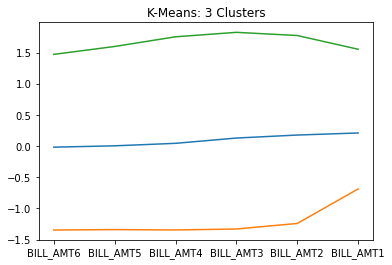

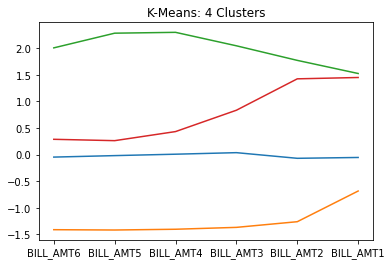

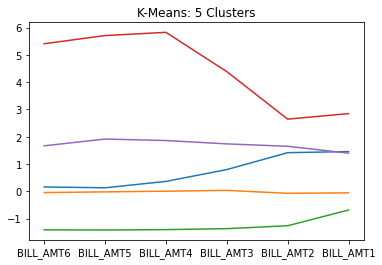

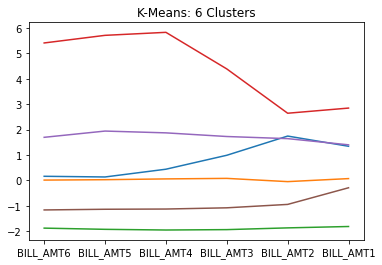

In [38]:
# visualize results
for key, item in _kmeans_pay.items():
    plot_average(item.cluster_centers_, 'K-Means: {} Clusters'.format(key), bill_amt_features)
    plt.show()

Not much of a trend, because the since `BILL_AMT` is dependent on `LIMIT_BALL`, all we are saying here is that there are three broad groups of people with a specific limit balance. That is, we are just creating bins for `LIMIT_BAL`.

### Domain Expertise Encoding

## Additional Features

Five features to be tried out:

1. Average repayment status (categorical)

2. Average bill amount outstanding above/below average payment (categorical)

3. Average *change* in MoM repayment status

4. Short-term / Long-term billing trend

5. Frequency variables

### Average Repayment Status

In [39]:
# @helper method
def get_avg(df, features):
    data = df.copy()
    total = 0
    for feat in features: total += data[feat]
    return total / len(features)  

In [40]:
# list of all pay features
pay_features = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

# compute
X_train_aug = df_train.copy()
X_train_aug['AVG_PAY'] = get_avg(df_train, pay_features)

### Average Bill Amount Outstanding vs Average Payment ('Sufficiency')

In [41]:
# lists of pay amount and bill amount features
pay_amt_features = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
bill_features = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']

# Compute
X_train_aug['AVG_BILL_AMT'] = get_avg(X_train_aug, bill_features)
X_train_aug['AVG_PAY_AMT'] = get_avg(X_train_aug, pay_amt_features)

X_train_aug['SUFF'] = np.where(X_train_aug['AVG_BILL_AMT'] <= X_train_aug['AVG_PAY_AMT'], 1, 0)

### Average Change in MoM Repayment Status

In [42]:
# create dummies
dummy_train = X_train_aug.copy()

# compute deltas and mean delta
dummy_train['DELTA_12'] = dummy_train['PAY_2'] - dummy_train['PAY_1']
dummy_train['DELTA_23'] = dummy_train['PAY_3'] - dummy_train['PAY_2']
dummy_train['DELTA_34'] = dummy_train['PAY_4'] - dummy_train['PAY_3']
dummy_train['DELTA_45'] = dummy_train['PAY_5'] - dummy_train['PAY_4']
dummy_train['DELTA_56'] = dummy_train['PAY_6'] - dummy_train['PAY_5']
deltas = ['DELTA_12', 'DELTA_23', 'DELTA_34', 'DELTA_45', 'DELTA_56']
dummy_train['AVG_DELTA'] = dummy_train[deltas].mean(axis=1)
    
# create new feature
X_train_aug['AVG_PAY_DELTA'] = dummy_train['AVG_DELTA']

### Frequency Variables

In [43]:
# compute frequency of 3+ months overdue
for pay_feature in pay_features:
    X_train_aug['FREQ_{}'.format(pay_feature)] = np.where((X_train_aug[pay_feature] >= 3),1, 
                                                (np.where(X_train_aug[pay_feature] <3,0,X_train_aug[pay_feature])))

pay_delays = ['FREQ_PAY_1', 'FREQ_PAY_2','FREQ_PAY_3','FREQ_PAY_4','FREQ_PAY_5','FREQ_PAY_6',]
X_train_aug['PAY_DELAY_FREQ'] = X_train_aug[pay_delays].sum(axis=1)

# compute frequency of paying on time (-2;-1;0)
for pay_feature in pay_features:
    X_train_aug['TIMELY_{}'.format(pay_feature)] = np.where((X_train_aug[pay_feature] <= 0),1, 
                                                (np.where(X_train_aug[pay_feature] >0,0,X_train_aug[pay_feature])))

pay_timely = ['TIMELY_PAY_1', 'TIMELY_PAY_2','TIMELY_PAY_3','TIMELY_PAY_4','TIMELY_PAY_5','TIMELY_PAY_6',]
X_train_aug['PAY_TIMELY_FREQ'] = X_train_aug[pay_timely].sum(axis=1)

# drop extra columns
X_train_aug.drop(pay_delays, axis=1, inplace=True)
X_train_aug.drop(pay_timely, axis=1, inplace=True)

In [44]:
# list of onthly repayment features
pay_amounts = ['PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']

# compute frequency of having monthly repayments > 0
for pay_amt_feature in pay_amt_features:
    X_train_aug['FREQ_{}'.format(pay_amt_feature)] = np.where((X_train_aug[pay_amt_feature] > 0),1, 
                                                (np.where(X_train_aug[pay_amt_feature] <=0,0,
                                                 X_train_aug[pay_amt_feature])))

repayments = ['FREQ_PAY_AMT1', 'FREQ_PAY_AMT2','FREQ_PAY_AMT3','FREQ_PAY_AMT4','FREQ_PAY_AMT5','FREQ_PAY_AMT6',]
X_train_aug['REPAY_FREQ'] = X_train_aug[repayments].sum(axis=1)

# drop extra columns
X_train_aug.drop(repayments, axis=1, inplace=True)

In [45]:
# print final list of features
print(list(X_train_aug.columns))

# moving back to df_train
df_train = X_train_aug.copy()

['AGE_BIN_1', 'AGE_BIN_2', 'AGE_BIN_3', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4', 'LIMIT_BAL', 'MARRIAGE_0', 'MARRIAGE_1', 'MARRIAGE_2', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'SEX_1', 'SEX_2', 'DEFAULT', 'PAY_CLUSTER_0', 'PAY_CLUSTER_1', 'PAY_CLUSTER_2', 'PAY_CLUSTER_3', 'PAY_AMT_CLUSTER_0', 'PAY_AMT_CLUSTER_1', 'PAY_AMT_CLUSTER_2', 'AVG_PAY', 'AVG_BILL_AMT', 'AVG_PAY_AMT', 'SUFF', 'AVG_PAY_DELTA', 'PAY_DELAY_FREQ', 'PAY_TIMELY_FREQ', 'REPAY_FREQ']


## Feature Selection

In [46]:
# re-define features post-feature engineering
cols = df_train.columns.values
to_drop = ['DEFAULT']
features = np.setdiff1d(cols, to_drop)

# inspect
features

array(['AGE_BIN_1', 'AGE_BIN_2', 'AGE_BIN_3', 'AVG_BILL_AMT', 'AVG_PAY',
       'AVG_PAY_AMT', 'AVG_PAY_DELTA', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'EDUCATION_1',
       'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4', 'LIMIT_BAL',
       'MARRIAGE_0', 'MARRIAGE_1', 'MARRIAGE_2', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'PAY_AMT1', 'PAY_AMT2',
       'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'PAY_AMT_CLUSTER_0', 'PAY_AMT_CLUSTER_1', 'PAY_AMT_CLUSTER_2',
       'PAY_CLUSTER_0', 'PAY_CLUSTER_1', 'PAY_CLUSTER_2', 'PAY_CLUSTER_3',
       'PAY_DELAY_FREQ', 'PAY_TIMELY_FREQ', 'REPAY_FREQ', 'SEX_1',
       'SEX_2', 'SUFF'], dtype=object)

### Weight-Based Approach

**Objective**:
* Instead of computing communities based off of the Louvain algorithm, whose maths are beyond the scope of the course, we can compute neighborhoods hierarchically by looking at the correlations between variables. Most clustering algorithms utilize Euclidean distance to determine the proximity of two points. For our case, we can instead use the reciprocal of the correlation as the distance. That way, two features that are very correlated (~ 1.0) will have a 'distance' of ~ 1.0 between them. However, others that are less correlated (~0) will have a much greater 'distance' between them. Thus, we can iteratively group features and create communities in this way. 

* To do so, we will utilize Sci-Kit Learn's Agglomerative Clustering algorithm, which admits precomputed distances as an input. Our precomputed distances will be a matrix with element-wise reciprocals of the correlation matrix. We will then visualize the successive clusters that are formed, and decide a level of hierarchy we wish to use. 

**Game Plan:**

1. Compute reciprocal of corr matrix and make values absolute (because distance must be positive)
2. Create Dendrograms using Scipy to see tree-form of clusters, and identify the optimal number of clusters to use in Sci-Kit Learn's `AgglomerativeClustering` model.
2. Feed the rec. corr matrix into an `agg` clustering model, which is characterized by:
    1. `average` linkage method, given its flexibility with weird datasets.
    2. `precomputed` affinity, since we are providing precomputed distances (in our case, the reciprocal of the corr matrix). 
3. Plot the resulting groups into a community graph that better visualizes the clusters of features.
4. Interpret these clusters.
5. Compute weights based on the summation x target variable correlation method

In [47]:
# select features to compute correlation matrix
df_features = df_train[features]
df_features_corr = df_features.corr()

# convert to numpy matrix
corr_matrix = np.asmatrix(df_features_corr)

# extract correlations with target label, and drop target's correlation
# with itself
target_corr = df_train.corr().loc['DEFAULT', :].to_numpy()
target_index = np.where(target_corr == 1.0)
target_corr = np.delete(target_corr, target_index)

# sanity check: assert same num. features as num. correlations
assert len(features) == len(target_corr)

# Creates graph using the data from the correlation matrix
G = nx.from_numpy_matrix(corr_matrix)

# relabels nodes to match features
G = nx.relabel_nodes(G, lambda x: features[x])

# shows the edges with their corresponding weights
G.edges(data=True)

EdgeDataView([('AGE_BIN_1', 'AGE_BIN_1', {'weight': 1.0}), ('AGE_BIN_1', 'AGE_BIN_2', {'weight': -0.6795564000298462}), ('AGE_BIN_1', 'AGE_BIN_3', {'weight': -0.10590312760959729}), ('AGE_BIN_1', 'AVG_BILL_AMT', {'weight': -0.021190732533674973}), ('AGE_BIN_1', 'AVG_PAY', {'weight': -0.040532173870374354}), ('AGE_BIN_1', 'AVG_PAY_AMT', {'weight': 0.013108693053422254}), ('AGE_BIN_1', 'AVG_PAY_DELTA', {'weight': 0.01270646553795781}), ('AGE_BIN_1', 'BILL_AMT1', {'weight': -0.021414740784865254}), ('AGE_BIN_1', 'BILL_AMT2', {'weight': -0.021266242785400225}), ('AGE_BIN_1', 'BILL_AMT3', {'weight': -0.02193497972787528}), ('AGE_BIN_1', 'BILL_AMT4', {'weight': -0.01926564397903945}), ('AGE_BIN_1', 'BILL_AMT5', {'weight': -0.018071375288104458}), ('AGE_BIN_1', 'BILL_AMT6', {'weight': -0.019615233067912907}), ('AGE_BIN_1', 'EDUCATION_1', {'weight': 0.14331493294222727}), ('AGE_BIN_1', 'EDUCATION_2', {'weight': 0.08769212511542393}), ('AGE_BIN_1', 'EDUCATION_3', {'weight': -0.13408438849223273

In [48]:
# compute element-wise reciprocal of correlation matrix
# Note: we subtract 1 so that the diagonal of the matrix equals 0, 
# meaning that the same point has a '0 distance' from itself
r_corr_matrix = np.abs(np.reciprocal(corr_matrix)) - 1

# sanity check: assert same shape
assert(r_corr_matrix.shape == corr_matrix.shape)

In [49]:
# convert the redundant n*n r_corr_matrix matrix form into a condensed 
# nC2 array for Scipy's method
import scipy.spatial.distance as ssd
distArray = ssd.squareform(r_corr_matrix) # distArray[{n choose 2}-{n-i choose 2} + (j-i-1)] is the distance between points i and j

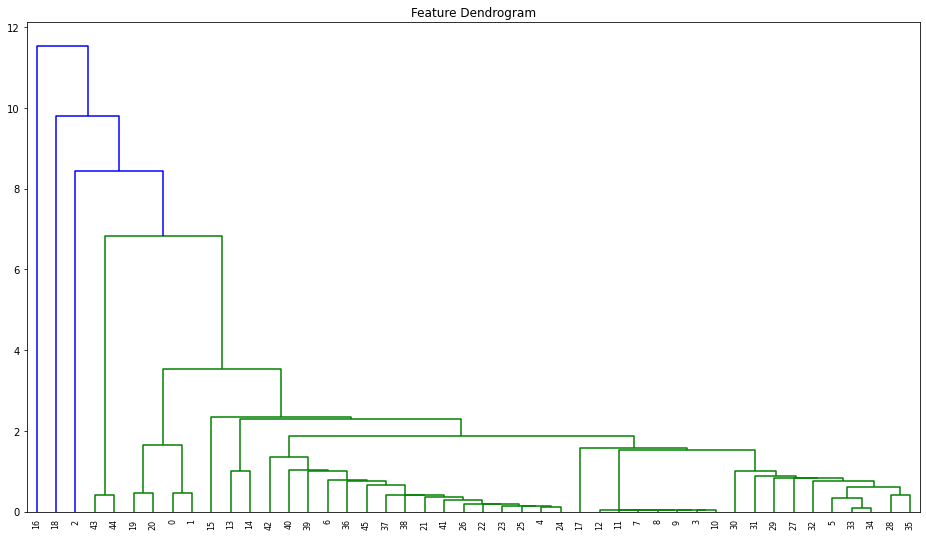

In [50]:
# plot dendogram using scipy hierarchical clustering to identify optimal
# number of clusters
plt.figure(figsize=(16,9))
plt.title("Feature Dendrogram")
dend = sch.dendrogram(sch.linkage(distArray, method='single'))

Note that we choose the 'Average' linkage method because it is the most suitable for weird-shaped datasets like ours, since we aren't using Euclidean distance but rather another arbitrary metric.

From this graph, we can draw a horizontal line right around 75 that gives us the longest distance of a vertical line before reaching a horizontal line (i.e. a linkage). At this point, we an clearly identify that there are 3 main clusters. Thus, we pick `n_clusters = 3` in our `AgglomerativeClustering` algorithm.

In [51]:
# instantiate agg clusterer with 'precomputed' affinity
agg = AgglomerativeClustering(n_clusters=3, 
                              affinity='precomputed',
                              linkage='average')

# cluster
clusters_3 = agg.fit_predict(r_corr_matrix)

In [52]:
############################################################################################
# The following code is attributable verbatim to 
# Paul Brodersen, who published it on StackOverflow
# on April 21, 2017, at:
# https://stackoverflow.com/questions/43541376/how-to-draw-communities-with-networkx

def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=3., seed=40)

    pos_nodes = _position_nodes(g, partition, scale=1.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos

############################################################################################

In [53]:
# check that feature and node order are the same
assert (f == g for f, g in zip(features, np.array(list(G.nodes))))

In [54]:
# Function to display the basic graph

def create_neighborhood_network(G, min_corr, partition, labels):
    
    # create copy
    H = G.copy()
    
    # checks all edges and removes some based on corr_dir, and min_corr
    #for feat_1, feat_2, weight in G.edges(data=True):
    #    if abs(weight['weight']) < min_corr:
    #        H.remove_edge(feat_1, feat_2)
    
    # create list for the edges and for the weights
    edges, weights = zip(*nx.get_edge_attributes(H,'weight').items())
    
    # increase weight values to make vals more distinct 
    weights = tuple([(1 + abs(x))**2 for x in weights])
    
    # positions
    positions = community_layout(H, partition)
    
    # fig size
    plt.figure(figsize=(15,15))
    
    # draws nodes
    nx.draw_networkx_nodes(H, 
                           positions,
                           labels,
                           node_color=list(partition.values()),
                           node_size=500, 
                           alpha=0.8)
    
    # styling for labels
    nx.draw_networkx_labels(H, 
                            positions, 
                            font_size=8,
                            font_family='sans-serif')
    
    # color setting
    main_color = plt.cm.GnBu
    
    # draws the edges
    nx.draw_networkx_edges(H, 
                           positions, 
                           edgelist=edges, 
                           style='solid',
                           width=weights,
                           edge_color=weights,
                           edge_cmap=main_color,
                           edge_vmin=min(weights),
                           edge_vmax=max(weights))
    
    # displays the graph without axis
    plt.axis('off')
    
    # show
    plt.show()

In [55]:
# instantiate agg clusterer with 'precomputed' affinity
agg = AgglomerativeClustering(n_clusters=5, 
                              affinity='precomputed',
                              linkage='average')

# cluster
clusters = agg.fit_predict(r_corr_matrix)

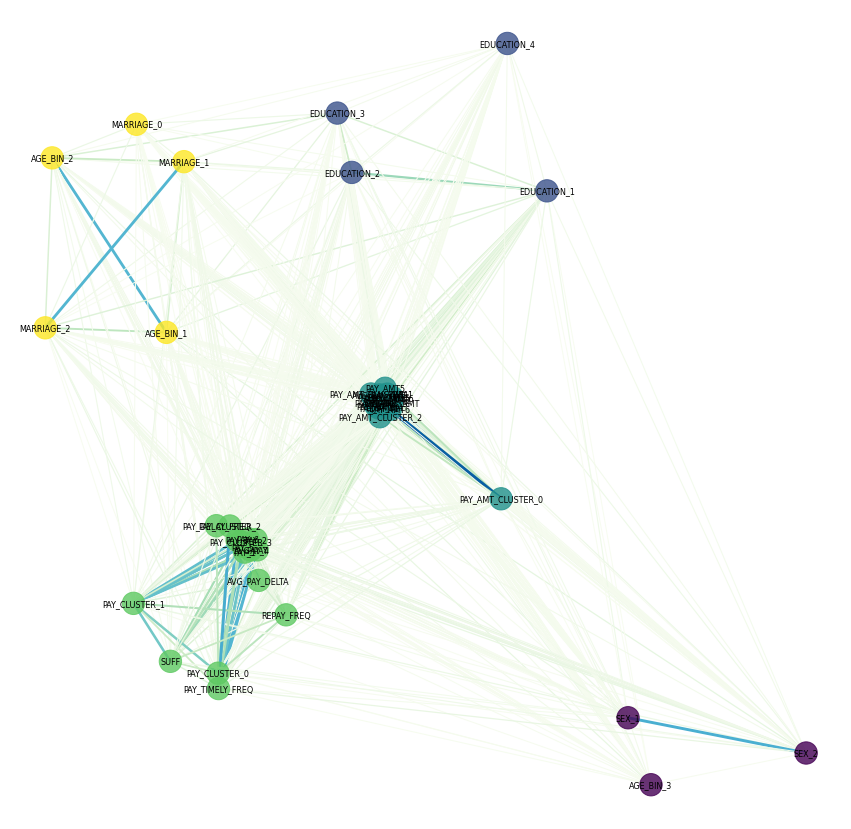

In [56]:
# create dict mapping each feature to its cluster
cluster_assignments = {}
for f, c in zip(features, clusters):
    cluster_assignments[f] = c

# plot
create_neighborhood_network(G, 0.0, cluster_assignments, features)

It is interesting to note the clusters that appear:
1. `AGE_BIN

In [57]:
# Now, we ompute the weights of each 
# feature using their within-neighborhood sum of correlations and multiplying
# them by the target variable.

# we define total corr as the summation of feature corrs within their 
# neighborhoods
total_corr = {}

# get edges of graph
edges = G.edges(data=True)

# iterate over neighborhood and sum over weights 
for feat in features:
    total_corr[feat] = 0
    for feat_i, feat_j, weight in edges:
        if feat == feat_i:
            if feat != feat_j and cluster_assignments[feat_i] == cluster_assignments[feat_j]:
                total_corr[feat] += np.abs(weight['weight'])
                
# multiply total corr for each variable by its correlation with
# the target label
total_weights = {}
for i, feat in enumerate(features):
    total_weights[feat] = total_corr[feat] * np.abs(target_corr[i])

In [58]:
# create df with both total_weights and assignment_3,
# then groupby neighborhood and sort by total_weight

# sanity check: assert same feature order
assert (k == v for k, v in zip(cluster_assignments.keys(), total_weights.keys()))
        
# create separate dfs
df_cluster_assignments = pd.DataFrame.from_dict(cluster_assignments, orient='index')
df_weights = pd.DataFrame.from_dict(total_weights, orient='index')

# join on index
df_neighborhoods = df_cluster_assignments.merge(df_weights, left_index=True, right_index=True)
df_neighborhoods.columns = ['NBRHOOD', 'WEIGHT']

# make weights absolute so that strong negative correlations are also given
# importance
df_neighborhoods['WEIGHT'] = np.abs(df_neighborhoods['WEIGHT'])

# inspect
df_neighborhoods

,NBRHOOD,WEIGHT
AGE_BIN_1,4,0.236490
AGE_BIN_2,4,0.095116
AGE_BIN_3,0,0.001939
AVG_BILL_AMT,2,0.266336
AVG_PAY,3,0.216203
AVG_PAY_AMT,2,0.169118
AVG_PAY_DELTA,3,0.050907
BILL_AMT1,2,0.062077
BILL_AMT2,2,0.039237
BILL_AMT3,2,1.038962


In [59]:
# define method for returning top n features in each neighborhood
def get_top_features(n, group_col, weight_col, df=df_neighborhoods):
    
    # sort df
    df_sorted = df.sort_values(by=[group_col, weight_col], ascending=[True, False])
    
    # get unique groups
    groups = np.unique(df_sorted[group_col])
    
    # create empty dict
    top_features_full = {}
    top_features = {}
    
    # pick top n from each group
    for g in groups:
        if g not in top_features_full.keys(): 
            top_features_full[g] = []
        if g not in top_features.keys():
            top_features[g] = []
            
        subset = df[df[group_col] == g].sort_values(weight_col, ascending=False).iloc[:n, :]
        for index, row in subset.iterrows():
            top_features_full[g].append({index: row[weight_col]})
            top_features[g].append(index)
            
    return top_features, top_features_full

In [60]:
# test
top_3, top_3_full = get_top_features(n=3, group_col='NBRHOOD', weight_col='WEIGHT')

# inspect
top_3

{0: ['SEX_1', 'AGE_BIN_3', 'SEX_2'],
 1: ['EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3'],
 2: ['BILL_AMT3', 'LIMIT_BAL', 'BILL_AMT4'],
 3: ['PAY_1', 'PAY_2', 'PAY_3'],
 4: ['AGE_BIN_1', 'MARRIAGE_1', 'AGE_BIN_2']}

In [61]:
# helper method to get feature df
def get_df_features(df, features):
    return df[features]

In [62]:
# collapse features
top_n = top_3
best_features = []
for v in top_n.values():
    for i in v:
        best_features.append(i)

In [63]:
# get final features
df_weighted_features = get_df_features(df_train, best_features)

# inspect
df_weighted_features.head()

,SEX_1,AGE_BIN_3,SEX_2,EDUCATION_1,EDUCATION_2,EDUCATION_3,BILL_AMT3,LIMIT_BAL,BILL_AMT4,PAY_1,PAY_2,PAY_3,AGE_BIN_1,MARRIAGE_1,AGE_BIN_2
0,0,0,1,0,1,0,689,20000,0,2,2,-1,1,1,0
1,0,0,1,0,1,0,2682,120000,3272,-1,2,0,1,0,0
2,0,0,1,0,1,0,13559,90000,14331,0,0,0,1,0,0
3,0,0,1,0,1,0,49291,50000,28314,0,0,0,1,1,0
4,1,0,0,0,1,0,35835,50000,20940,-1,0,-1,0,1,1


### Heuristics Approach

The Heuristics approach is motivated by the fact that the neighborhoods of features evidently carry different characteristics. Thus, there is a question: 

**Is there a specific neighborhood that by itself provides greater predictive power?**

Thus, we will proceed in a simple manner:

1. Compute the within-neighborhood sum of the features' correlations with the target variable
2. Select the highest-ranking neighborhood as the set of features

In [64]:
# form df with features, neighborhoods, and target correlations
# since they are ordered in the same way as the index
df_cluster_assignments.columns = ['NBRHOOD']
df_cluster_assignments['TGT_CORR'] = np.abs(target_corr)

# inspect
df_cluster_assignments.head()

,NBRHOOD,TGT_CORR
AGE_BIN_1,4,0.175584
AGE_BIN_2,4,0.146331
AGE_BIN_3,0,0.035699
AVG_BILL_AMT,2,0.032777
AVG_PAY,3,0.024245


In [65]:
# determine top neighborhood
df_cluster_assignments.groupby('NBRHOOD').sum().sort_values('TGT_CORR', ascending=False)

,TGT_CORR
NBRHOOD,
2,2.413007
3,1.740389
4,1.099625
1,0.597983
0,0.528862


In [66]:
# get features for top neighborhood
top_nbr = df_cluster_assignments.groupby('NBRHOOD').sum().sort_values('TGT_CORR', ascending=False).index[0]
top_neighborhood = []
for index, row in df_cluster_assignments[df_cluster_assignments['NBRHOOD'] == top_nbr].iterrows():
    top_neighborhood.append(index)
# examine
top_neighborhood

['AVG_BILL_AMT',
 'AVG_PAY_AMT',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'LIMIT_BAL',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'PAY_AMT_CLUSTER_0',
 'PAY_AMT_CLUSTER_1',
 'PAY_AMT_CLUSTER_2']

In [67]:
# get df
df_nbr_features = get_df_features(df_train, top_neighborhood)

# inspect
df_nbr_features.head()

,AVG_BILL_AMT,AVG_PAY_AMT,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,LIMIT_BAL,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,PAY_AMT_CLUSTER_0,PAY_AMT_CLUSTER_1,PAY_AMT_CLUSTER_2
0,1284.000000,114.833333,3913,3102,689,0,0,0,20000,0,689,0,0,0,0,1,0,0
1,2846.166667,833.333333,2682,1725,2682,3272,3455,3261,120000,0,1000,1000,1000,0,2000,1,0,0
2,16942.166667,1836.333333,29239,14027,13559,14331,14948,15549,90000,1518,1500,1000,1000,1000,5000,1,0,0
3,38555.666667,1398.000000,46990,48233,49291,28314,28959,29547,50000,2000,2019,1200,1100,1069,1000,1,0,0
4,18223.166667,9841.500000,8617,5670,35835,20940,19146,19131,50000,2000,36681,10000,9000,689,679,1,0,0


In [68]:
df_nbr_features.shape

(36212, 18)

### PCA Approach

In [69]:
# select data
X = df_train[features]
y = df_train['DEFAULT']

# standardise data
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X.values), 
                        index=X.index, columns=X.columns)


In [70]:
X_scaled

,AGE_BIN_1,AGE_BIN_2,AGE_BIN_3,AVG_BILL_AMT,AVG_PAY,AVG_PAY_AMT,AVG_PAY_DELTA,BILL_AMT1,BILL_AMT2,BILL_AMT3,...,PAY_CLUSTER_0,PAY_CLUSTER_1,PAY_CLUSTER_2,PAY_CLUSTER_3,PAY_DELAY_FREQ,PAY_TIMELY_FREQ,REPAY_FREQ,SEX_1,SEX_2,SUFF
0,0.734860,-0.499379,-0.077824,-0.686495,-0.322893,-0.536978,-3.114959,-0.638934,-0.646116,-0.672351,...,-0.997242,-0.569569,-0.322058,2.270542,-0.175885,-0.392168,-2.288308,-0.662558,0.937444,-0.394186
1,0.734860,-0.499379,-0.077824,-0.661281,0.499753,-0.446423,2.806953,-0.656254,-0.666029,-0.642537,...,1.002765,-0.569569,-0.322058,-0.440423,-0.175885,-0.392168,-0.521744,-0.662558,0.937444,-0.394186
2,0.734860,-0.499379,-0.077824,-0.433758,0.006166,-0.320012,0.268991,-0.282591,-0.488135,-0.479820,...,1.002765,-0.569569,-0.322058,-0.440423,-0.175885,0.664193,0.655965,-0.662558,0.937444,-0.394186
3,0.734860,-0.499379,-0.077824,-0.084897,0.006166,-0.375257,0.268991,-0.032830,0.006502,0.054719,...,1.002765,-0.569569,-0.322058,-0.440423,-0.175885,0.664193,0.655965,-0.662558,0.937444,-0.394186
4,-1.360804,2.002489,-0.077824,-0.413082,-0.322893,0.688902,1.114978,-0.572747,-0.608982,-0.146579,...,1.002765,-0.569569,-0.322058,-0.440423,-0.175885,0.664193,0.655965,1.509302,-1.066731,-0.394186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36207,0.734860,-0.499379,-0.077824,0.384034,0.170695,-0.255904,-0.576996,0.561511,0.571678,0.630187,...,1.002765,-0.569569,-0.322058,-0.440423,-0.175885,0.136013,0.655965,-0.662558,-1.066731,-0.394186
36208,0.734860,-0.499379,-0.077824,-0.255646,0.499753,-0.380592,0.268991,-0.331035,-0.288088,-0.256457,...,-0.997242,-0.569569,-0.322058,2.270542,-0.175885,-0.920349,0.655965,-0.662558,-1.066731,-0.394186
36209,0.734860,-0.499379,-0.077824,-0.246363,0.006166,-0.424452,0.268991,-0.020280,0.020861,0.037306,...,1.002765,-0.569569,-0.322058,-0.440423,-0.175885,0.664193,0.655965,-0.662558,0.937444,-0.394186
36210,0.734860,-0.499379,-0.077824,0.377212,0.006166,-0.237902,0.268991,0.364373,0.427231,0.481578,...,1.002765,-0.569569,-0.322058,-0.440423,-0.175885,0.664193,0.067110,-0.662558,-1.066731,-0.394186


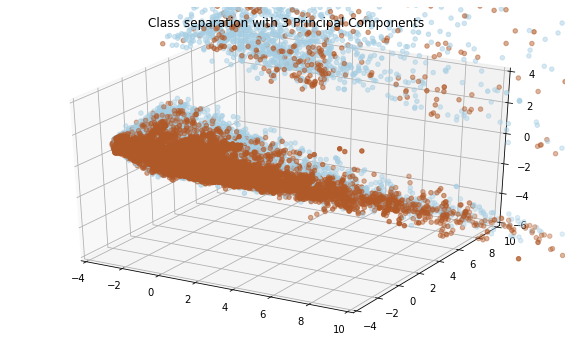

In [71]:
# checking results 3 principal components
projected = PCA(n_components=3).fit_transform(X_scaled)

# plotting the training points on all 3 dimensions
fig = plt.figure(figsize=(10,6))
ax = fig.gca(projection='3d')
ax.scatter(projected[:, 0], projected[:, 1], projected[:, 2], c=y, cmap=cm.Paired)

ax.set_xlim(-4, 10)
ax.set_ylim(-4, 10)
ax.set_zlim(-6, 4)

plt.title('Class separation with 3 Principal Components')

plt.show()

As we can see, the variance is not explained sufficiently by only 3 components out of the original XX features - significant overlapping can be observed. Therefore, we need to plot the explained variance by the number of components.



Text(0, 0.5, 'Explained Variance')

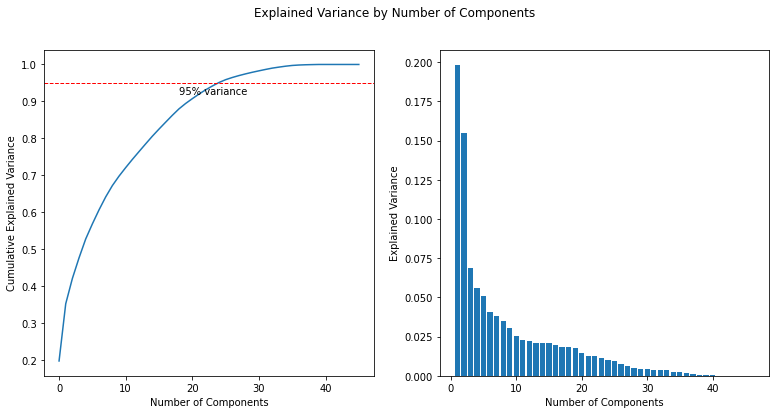

In [72]:
# fit the PCA model
pca = PCA().fit(X_scaled)

# explained variance by number of components
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,6))
fig.suptitle('Explained Variance by Number of Components')

# plot cumulative explained variance
ax1.plot(np.cumsum(pca.explained_variance_ratio_))
ax1.set_xlabel("Number of Components")
ax1.set_ylabel("Cumulative Explained Variance")
ax1.axhline(y=.95, xmin=0, xmax=100, linewidth=1, color='r', ls='--', label='Old')
ax1.annotate('95% variance', xy=(20, 0.9), xytext=(18, 0.92))

# scree plot
ax2.bar(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
ax2.set_xlabel("Number of Components")
ax2.set_ylabel("Explained Variance")

In [73]:
# determine necessary components for 95% variance
cum_sum = 0
for i, r in enumerate(pca.explained_variance_ratio_):
    cum_sum += r
    if cum_sum >= 0.95:
        print('Num. Components: ', i)
        print('Explained Variance: {:.2f}%'.format(cum_sum * 100))
        break

Num. Components:  24
Explained Variance: 95.11%


In [74]:
# create new PCA with 25 components and transform data
pca_25 = PCA(n_components=25)
X_pca = pca_25.fit_transform(X_scaled)

In [75]:
# create df
df_pca_25 = pd.DataFrame(X_pca)
df_pca_25.columns = ['PC_{}'.format(i) for i in range(1,26)]

# inspect
df_pca_25.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_16,PC_17,PC_18,PC_19,PC_20,PC_21,PC_22,PC_23,PC_24,PC_25
0,-1.952192,-1.881081,-0.782490,3.159530,1.631886,-3.452556,-1.558383,0.502254,-0.634947,-0.356041,...,0.772856,1.009947,-0.187946,0.184273,0.464382,-1.178091,-0.656070,0.131428,0.083351,0.818242
1,-0.120746,-1.958495,0.528042,-3.184282,-0.056594,0.507751,-1.280722,0.050882,-0.722385,0.268201,...,-0.366024,-0.079147,-0.078946,-0.187475,1.424979,-0.375344,-0.725697,0.141789,-1.018376,0.900495
2,-0.653163,-0.754815,-0.364504,-2.435785,0.480918,-0.830785,-1.135595,0.086580,-0.569998,0.601930,...,-0.031858,0.091896,-0.093591,-0.252284,0.110870,-0.084564,0.378290,0.039142,-0.038635,-0.225237
3,-0.071358,-0.357610,-0.863956,-1.339802,-1.079008,-0.804072,-1.673986,0.139799,-1.087786,-0.620071,...,0.115362,0.131141,-0.028435,-0.215967,0.043078,-0.205816,-0.110986,0.512969,0.317436,-0.327787
4,-0.626408,0.328011,0.553530,-0.847746,-3.635211,-0.732560,1.484049,0.910774,-1.399951,-0.486911,...,0.346111,0.459234,-0.139115,-0.125085,0.352984,-0.136139,0.234909,0.741184,0.703514,0.586577


In [76]:
df_pca_25.describe()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_16,PC_17,PC_18,PC_19,PC_20,PC_21,PC_22,PC_23,PC_24,PC_25
count,3.621200e+04,3.621200e+04,3.621200e+04,3.621200e+04,3.621200e+04,3.621200e+04,3.621200e+04,3.621200e+04,3.621200e+04,3.621200e+04,...,3.621200e+04,3.621200e+04,3.621200e+04,3.621200e+04,3.621200e+04,3.621200e+04,3.621200e+04,3.621200e+04,3.621200e+04,3.621200e+04
mean,3.767376e-17,6.278959e-17,-6.435933e-17,-6.278959e-17,-1.098818e-16,-1.255792e-17,5.356737e-17,-2.943262e-17,3.767376e-17,6.906855e-17,...,3.453428e-17,7.848699e-18,-1.106667e-16,-1.051726e-16,-2.511584e-17,-3.767376e-17,-2.511584e-17,-7.534751e-17,-2.683274e-17,-3.924350e-17
std,3.018901e+00,2.667085e+00,1.775663e+00,1.602057e+00,1.531394e+00,1.368636e+00,1.322210e+00,1.268607e+00,1.185912e+00,1.085378e+00,...,9.430537e-01,9.269653e-01,9.226883e-01,8.964439e-01,8.202245e-01,7.716701e-01,7.555653e-01,7.272731e-01,6.875133e-01,6.604876e-01
min,-5.751330e+00,-1.078189e+01,-6.977467e+00,-3.954683e+00,-4.664593e+00,-5.185220e+00,-2.820180e+00,-8.252966e+00,-3.900686e+00,-3.388678e+00,...,-1.929941e+01,-2.049821e+01,-2.945794e+01,-1.637389e+01,-4.871028e+00,-3.411882e+00,-4.212021e+00,-3.853687e+00,-3.838627e+00,-4.407871e+00
25%,-1.962341e+00,-1.227552e+00,-6.663875e-01,-1.275901e+00,-1.063811e+00,-8.674089e-01,-1.129756e+00,-1.329826e-01,-9.651998e-01,-6.937977e-01,...,-2.849751e-01,-2.634271e-01,-1.271378e-01,-2.256334e-01,-4.690195e-01,-3.610895e-01,-4.481765e-01,-4.533239e-01,-3.469486e-01,-3.011575e-01
50%,-8.323149e-02,-1.021470e-01,-2.515525e-01,-9.763426e-02,1.878994e-01,-9.401436e-02,-4.376446e-01,6.745727e-03,7.571211e-02,-1.257156e-01,...,-1.636174e-03,1.091751e-02,8.361685e-03,-7.057471e-02,7.395604e-02,-7.922773e-02,1.345564e-02,6.689794e-02,4.520129e-02,-2.172996e-02
75%,1.733823e+00,1.002106e+00,2.819255e-01,1.114767e+00,1.099237e+00,8.752930e-01,1.364284e+00,1.396627e-01,9.128134e-01,6.241793e-01,...,2.274464e-01,2.549879e-01,1.706222e-01,1.887569e-01,4.692514e-01,4.359972e-01,4.300567e-01,4.718826e-01,3.373689e-01,3.309466e-01
max,2.849732e+01,4.535432e+01,4.068055e+01,7.877838e+00,5.954956e+00,7.782734e+00,3.605757e+00,6.614749e+01,4.150512e+00,7.626154e+00,...,1.964205e+01,3.184334e+01,3.637218e+01,3.119168e+01,5.092513e+00,5.594525e+00,1.189651e+01,4.649722e+00,1.874322e+01,2.915575e+01


## Pipelining Datasets

The Feature Engineering section has cleaned, augmented, and reduced the original dataset into **three sets of features**, each for a corresponding Feature Selection method. Each method and their corresponding DataFrame (excl. target var.) is listed below:

1. Weighted Approach: `df_weighted_features`
2. Heuristic Approach: `df_nbr_features`
3. PCA Approach: `df_pca_25`

In [77]:
# feat eng pipeline
def feat_eng_pipeline(df):
    '''
    Returns engineered dataset.
    '''
    # create bins for 'AGE'
    df['AGE_BIN'] = pd.cut(df['AGE'],
                              bins=[20,40,60,100],
                              labels=[1,2,3])
    # drop 'AGE'
    df.drop(['AGE'], axis=1, inplace=True)
    # Group 4,5,6,0 categories for 'EDUCATION'
    ed_map = {1:1, 2:2, 3:3, 4:4, 5:4, 6:4, 0:4}
    df.EDUCATION = df.EDUCATION.map(ed_map)
    # Group 0, 3 categories for 'MARRIAGE'
    marr_map = {0:0, 1:1, 2:2, 3:0}
    df.MARRIAGE = df.MARRIAGE.map(marr_map)
    # encoding categoricals
    categoricals = ['SEX', 'EDUCATION', 'MARRIAGE', 'AGE_BIN']
    for col in categoricals: 
        df[col] = df[col].astype('category')
    # create dummy cols, join, and drop old
    cat_df = df[categoricals]
    cat_df = pd.get_dummies(cat_df)
    df = df.join(cat_df).drop(categoricals, axis=1)
    
    # define features
    pay_features = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
    pay_amt_features = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
    
    # create PAY clusters
    df_pay = df[pay_features]
    pay_clusters = _kmeans_pay[3].predict(df_pay)
    df_pay_clusters = pd.DataFrame({'PAY_CLUSTER':pay_clusters})
    df_pay_clusters['PAY_CLUSTER'] = df_pay_clusters['PAY_CLUSTER'].astype('category')
    
    # one-hot encode
    cat_df_pc = pd.get_dummies(df_pay_clusters)
    cat_df_pc.index = df.index
    df = df.join(cat_df_pc)
    
    # create PAY_AMT clusters
    df_pay_amt = df[pay_amt_features]
    pay_amt_clusters = _kmeans_pay_amt[3].predict(df_pay_amt)
    df_pay_amt_clusters = pd.DataFrame({'PAY_AMT_CLUSTER':pay_amt_clusters})
    df_pay_amt_clusters['PAY_AMT_CLUSTER'] = df_pay_amt_clusters['PAY_AMT_CLUSTER'].astype('category')
    
    # one-hot encode
    cat_df_pamtc = pd.get_dummies(df_pay_amt_clusters)
    cat_df_pamtc.index = df.index
    df = df.join(cat_df_pamtc)
    
    # average repayment status
    df['AVG_PAY'] = get_avg(df, pay_features)
    
    # 'sufficiency'
    pay_amt_features = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
    bill_features = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
    df['AVG_BILL_AMT'] = get_avg(df, bill_features)
    df['AVG_PAY_AMT'] = get_avg(df, pay_amt_features)
    df['SUFF'] = np.where(df['AVG_BILL_AMT'] <= df['AVG_PAY_AMT'], 1, 0)
     
    # average change in MoM repayment status
    dummy_train = df.copy()
    dummy_train['DELTA_12'] = dummy_train['PAY_2'] - dummy_train['PAY_1']
    dummy_train['DELTA_23'] = dummy_train['PAY_3'] - dummy_train['PAY_2']
    dummy_train['DELTA_34'] = dummy_train['PAY_4'] - dummy_train['PAY_3']
    dummy_train['DELTA_45'] = dummy_train['PAY_5'] - dummy_train['PAY_4']
    dummy_train['DELTA_56'] = dummy_train['PAY_6'] - dummy_train['PAY_5']
    deltas = ['DELTA_12', 'DELTA_23', 'DELTA_34', 'DELTA_45', 'DELTA_56']
    dummy_train['AVG_DELTA'] = dummy_train[deltas].mean(axis=1)
    df['AVG_PAY_DELTA'] = dummy_train['AVG_DELTA']
    
    # frequency variables
    for pay_feature in pay_features:
        df['FREQ_{}'.format(pay_feature)] = np.where((df[pay_feature] >= 3),1, 
                                                    (np.where(df[pay_feature] <3,0, df[pay_feature])))
    pay_delays = ['FREQ_PAY_1', 'FREQ_PAY_2','FREQ_PAY_3','FREQ_PAY_4','FREQ_PAY_5','FREQ_PAY_6',]
    df['PAY_DELAY_FREQ'] = df[pay_delays].sum(axis=1)
    for pay_feature in pay_features:
        df['TIMELY_{}'.format(pay_feature)] = np.where((df[pay_feature] <= 0),1, 
                                                    (np.where(df[pay_feature] >0,0, df[pay_feature])))
    pay_timely = ['TIMELY_PAY_1', 'TIMELY_PAY_2','TIMELY_PAY_3','TIMELY_PAY_4','TIMELY_PAY_5','TIMELY_PAY_6',]
    df['PAY_TIMELY_FREQ'] = df[pay_timely].sum(axis=1)
    df.drop(pay_delays, axis=1, inplace=True)
    df.drop(pay_timely, axis=1, inplace=True)
    pay_amounts = ['PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']
    for pay_amt_feature in pay_amt_features:
        df['FREQ_{}'.format(pay_amt_feature)] = np.where((df[pay_amt_feature] > 0),1, 
                                                    (np.where(df[pay_amt_feature] <=0,0,
                                                     df[pay_amt_feature])))
    repayments = ['FREQ_PAY_AMT1', 'FREQ_PAY_AMT2','FREQ_PAY_AMT3','FREQ_PAY_AMT4','FREQ_PAY_AMT5','FREQ_PAY_AMT6',]
    df['REPAY_FREQ'] = df[repayments].sum(axis=1)
    df.drop(repayments, axis=1, inplace=True)
    
    return df

### Making Datasets

In [78]:
df_test_eng = feat_eng_pipeline(df_test) #preprocessing


## SCALING
scaler = StandardScaler()

# scaling unscaled train data
df_weighted_features_scaled = pd.DataFrame(scaler.fit_transform(df_weighted_features.values), 
                        index=df_weighted_features.index, columns=df_weighted_features.columns)# scaling unscalled train data
df_nbr_features_scaled = pd.DataFrame(scaler.fit_transform(df_nbr_features.values), 
                        index=df_nbr_features.index, columns=df_nbr_features.columns)

# scaling test data
df_test_eng_scaled = pd.DataFrame(scaler.fit_transform(df_test_eng.values), 
                        index=df_test_eng.index, columns=df_test_eng.columns)


df_test_weighted_features = get_df_features(df_test_eng_scaled.copy(), df_weighted_features.columns.values)
df_test_nbr_features = get_df_features(df_test_eng_scaled.copy(), df_nbr_features.columns.values)
df_test_pca_features = df_test_eng_scaled.copy()


In [79]:
X_train_WA = df_weighted_features_scaled
X_train_HA = df_nbr_features_scaled
X_train_PA = df_pca_25

X_test_WA = df_test_weighted_features
X_test_HA = df_test_nbr_features 
X_test_PA = pca_25.transform(df_test_eng)

dataset_WA = [X_train_WA, X_test_WA]
dataset_HA = [X_train_HA, X_test_HA]
dataset_PA = [X_train_PA, X_test_PA]

datasets = [[dataset_WA, 'Weighted Approach Dataset'], [dataset_HA, 'Heuristic Approach Dataset'], [dataset_PA, 'PCA Approach Dataset']] 


# target var => y values



In [80]:
print(X_test_HA.shape, X_train_HA.shape)

(6000, 18) (36212, 18)


In [81]:
X_train_WA.describe()

,SEX_1,AGE_BIN_3,SEX_2,EDUCATION_1,EDUCATION_2,EDUCATION_3,BILL_AMT3,LIMIT_BAL,BILL_AMT4,PAY_1,PAY_2,PAY_3,AGE_BIN_1,MARRIAGE_1,AGE_BIN_2
count,3.621200e+04,3.621200e+04,3.621200e+04,36212.000000,3.621200e+04,3.621200e+04,3.621200e+04,3.621200e+04,3.621200e+04,3.621200e+04,3.621200e+04,3.621200e+04,3.621200e+04,3.621200e+04,3.621200e+04
mean,-8.162647e-17,-7.848699e-18,3.139480e-17,0.000000,2.197636e-17,-4.395272e-17,-4.905437e-17,-8.162647e-17,1.177305e-18,3.139480e-17,-4.709220e-17,5.023167e-17,1.632529e-16,-3.453428e-17,-5.023167e-17
std,1.000014e+00,1.000014e+00,1.000014e+00,1.000014,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00
min,-6.625577e-01,-7.782394e-02,-1.066731e+00,-0.605725,-8.203634e-01,-3.646511e-01,-3.035277e+00,-1.134353e+00,-3.420648e+00,-1.962555e+00,-1.693028e+00,-1.649169e+00,-1.360804e+00,-7.729319e-01,-4.993786e-01
25%,-6.625577e-01,-7.782394e-02,-1.066731e+00,-0.605725,-8.203634e-01,-3.646511e-01,-6.380375e-01,-8.137133e-01,-6.364427e-01,-1.655251e-01,-8.688525e-01,-8.290686e-01,-1.360804e+00,-7.729319e-01,-4.993786e-01
50%,-6.625577e-01,-7.782394e-02,9.374436e-01,-0.605725,-8.203634e-01,-3.646511e-01,-3.816848e-01,-2.525940e-01,-3.672034e-01,-1.655251e-01,-4.467734e-02,-8.968291e-03,7.348597e-01,-7.729319e-01,-4.993786e-01
75%,1.509302e+00,-7.782394e-02,9.374436e-01,1.650913,1.218972e+00,-3.646511e-01,1.811467e-01,5.490051e-01,1.448609e-01,7.329900e-01,-4.467734e-02,-8.968291e-03,7.348597e-01,1.293775e+00,-4.993786e-01
max,1.509302e+00,1.284952e+01,9.374436e-01,1.650913,1.218972e+00,2.742348e+00,2.421157e+01,6.801478e+00,1.371411e+01,7.022595e+00,6.548724e+00,6.551835e+00,7.348597e-01,1.293775e+00,2.002489e+00


#Motivation:

In the larger scope of ML algorithms, we've now determinted that the most appropriate model for our situation is the SVM. 

However, these models have many intricacies  that vastly change their preformance and usabilty, thus, we will further our model selection to pick the most appropriate parameters for our model.

For this, we will take a "Darwinist" approach. By testing all these parameteres seperatly against a "baseline" SVM model (as defined by sklearn), and picking the best preforming one, we should be able to hypothetically create the "best" model for out dataset. However, there are some rammifications of not testing certain parameters together, which we will detail and talk about.

The SVM parameters we are evaulation are as such:

*  The type of kernel
*  The degree for polynomial kernels
*  The gamma kernel coefficent
* The shrinking heuristic
* The strength of the regularization parameter


However, it is also worth nothing that we won't experiment with some parameters. For example, we will be using the same tolerance for stoping criterion (1e-3) as we want to keep the bound on the relative error of our models comparable. 

#### additional imports

In [83]:
datasets[2][0][0].describe()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_16,PC_17,PC_18,PC_19,PC_20,PC_21,PC_22,PC_23,PC_24,PC_25
count,3.621200e+04,3.621200e+04,3.621200e+04,3.621200e+04,3.621200e+04,3.621200e+04,3.621200e+04,3.621200e+04,3.621200e+04,3.621200e+04,...,3.621200e+04,3.621200e+04,3.621200e+04,3.621200e+04,3.621200e+04,3.621200e+04,3.621200e+04,3.621200e+04,3.621200e+04,3.621200e+04
mean,3.767376e-17,6.278959e-17,-6.435933e-17,-6.278959e-17,-1.098818e-16,-1.255792e-17,5.356737e-17,-2.943262e-17,3.767376e-17,6.906855e-17,...,3.453428e-17,7.848699e-18,-1.106667e-16,-1.051726e-16,-2.511584e-17,-3.767376e-17,-2.511584e-17,-7.534751e-17,-2.683274e-17,-3.924350e-17
std,3.018901e+00,2.667085e+00,1.775663e+00,1.602057e+00,1.531394e+00,1.368636e+00,1.322210e+00,1.268607e+00,1.185912e+00,1.085378e+00,...,9.430537e-01,9.269653e-01,9.226883e-01,8.964439e-01,8.202245e-01,7.716701e-01,7.555653e-01,7.272731e-01,6.875133e-01,6.604876e-01
min,-5.751330e+00,-1.078189e+01,-6.977467e+00,-3.954683e+00,-4.664593e+00,-5.185220e+00,-2.820180e+00,-8.252966e+00,-3.900686e+00,-3.388678e+00,...,-1.929941e+01,-2.049821e+01,-2.945794e+01,-1.637389e+01,-4.871028e+00,-3.411882e+00,-4.212021e+00,-3.853687e+00,-3.838627e+00,-4.407871e+00
25%,-1.962341e+00,-1.227552e+00,-6.663875e-01,-1.275901e+00,-1.063811e+00,-8.674089e-01,-1.129756e+00,-1.329826e-01,-9.651998e-01,-6.937977e-01,...,-2.849751e-01,-2.634271e-01,-1.271378e-01,-2.256334e-01,-4.690195e-01,-3.610895e-01,-4.481765e-01,-4.533239e-01,-3.469486e-01,-3.011575e-01
50%,-8.323149e-02,-1.021470e-01,-2.515525e-01,-9.763426e-02,1.878994e-01,-9.401436e-02,-4.376446e-01,6.745727e-03,7.571211e-02,-1.257156e-01,...,-1.636174e-03,1.091751e-02,8.361685e-03,-7.057471e-02,7.395604e-02,-7.922773e-02,1.345564e-02,6.689794e-02,4.520129e-02,-2.172996e-02
75%,1.733823e+00,1.002106e+00,2.819255e-01,1.114767e+00,1.099237e+00,8.752930e-01,1.364284e+00,1.396627e-01,9.128134e-01,6.241793e-01,...,2.274464e-01,2.549879e-01,1.706222e-01,1.887569e-01,4.692514e-01,4.359972e-01,4.300567e-01,4.718826e-01,3.373689e-01,3.309466e-01
max,2.849732e+01,4.535432e+01,4.068055e+01,7.877838e+00,5.954956e+00,7.782734e+00,3.605757e+00,6.614749e+01,4.150512e+00,7.626154e+00,...,1.964205e+01,3.184334e+01,3.637218e+01,3.119168e+01,5.092513e+00,5.594525e+00,1.189651e+01,4.649722e+00,1.874322e+01,2.915575e+01


In [138]:
# function used to evaluate different SVM models
def evalModel(model, model_name, dataset, verbose = False):

  # every model is evaluated against the same test dataset
  X_train, X_test = dataset[0][0], dataset[0][1]
  
  #fit model
  model.fit(X_train,y_train)
    
  # use the model passed as a parameter to make predictions, which we will use to judge the model 
  predicted = model.predict(X_test).round()

  # metrics used here are: Accuracy, Recall, Precision, ROC/AUC and F1.
  # these are the industry standard and provide a proper, unbiased benchmark for models.
  accuracy_score = metrics.accuracy_score(y_test, predicted)
  recall_score = metrics.recall_score(y_test, predicted, average='micro')
  precision_score = metrics.precision_score(y_test, predicted, average='micro')
  roc_auc_score = metrics.roc_auc_score(y_test, predicted, average='micro')
  f1_score = metrics.f1_score(y_test, predicted, average='micro')

  if(verbose):
    print("Metrics for model name: " + model_name + " on " + str(dataset[1]))
    print("Accuracy score: " + accuracy_score.astype(str))
    print("Recall score: " + recall_score.astype(str))
    print("Precision_score: " + precision_score.astype(str))
    print("ROC/AUC score: " + roc_auc_score.astype(str))
    print("F1 score: " + f1_score.astype(str))
    print("\n")
    
  # return data for sorting later
  return [model_name,accuracy_score,recall_score,precision_score,roc_auc_score,f1_score]


def evalMetrics(prediction, y_test):
    """
    returns selected metrics of the prediction
    """
    accuracy_score = metrics.accuracy_score(y_test, prediction)
    recall_score = metrics.recall_score(y_test, prediction)
    precision_score = metrics.precision_score(y_test, prediction)
    roc_auc_score = metrics.roc_auc_score(y_test, prediction)
    f1_score = metrics.f1_score(y_test, prediction)
    
    print("Accuracy score: " + accuracy_score.astype(str))
    print("Recall score: " + recall_score.astype(str))
    print("Precision_score: " + precision_score.astype(str))
    print("ROC/AUC score: " + roc_auc_score.astype(str))
    print("F1 score: " + f1_score.astype(str))
    print("\n")
    return


In [85]:
# here we have our "baseline" SVM, as defined by sklearn. 
# let's get its preformance on each dataset to compare it to our other parameters:


Metrics for model name: baseline_SVM on Weighted Approach Dataset
Accuracy score: 0.5646666666666667
Recall score: 0.5646666666666667
Precision_score: 0.5646666666666667
ROC/AUC score: 0.6196767560272867
F1 score: 0.5646666666666667


Metrics for model name: baseline_SVM on Heuristic Approach Dataset
Accuracy score: 0.546
Recall score: 0.546
Precision_score: 0.546
ROC/AUC score: 0.6347547338302929
F1 score: 0.546


Metrics for model name: baseline_SVM on PCA Approach Dataset
Accuracy score: 0.789
Recall score: 0.789
Precision_score: 0.789
ROC/AUC score: 0.5
F1 score: 0.7890000000000001




In [86]:
#X_train_WA.describe()
for dataset in datasets:
    baseline_SVM = svm.SVC()
    evalModel(baseline_SVM, 'baseline_SVM', dataset, True);

          SEX_1  AGE_BIN_3     SEX_2  EDUCATION_1  EDUCATION_2  EDUCATION_3  \
0     -0.662558  -0.077824  0.937444    -0.605725     1.218972    -0.364651   
1     -0.662558  -0.077824  0.937444    -0.605725     1.218972    -0.364651   
2     -0.662558  -0.077824  0.937444    -0.605725     1.218972    -0.364651   
3     -0.662558  -0.077824  0.937444    -0.605725     1.218972    -0.364651   
4      1.509302  -0.077824 -1.066731    -0.605725     1.218972    -0.364651   
...         ...        ...       ...          ...          ...          ...   
36207 -0.662558  -0.077824 -1.066731    -0.605725    -0.820363    -0.364651   
36208 -0.662558  -0.077824 -1.066731    -0.605725    -0.820363    -0.364651   
36209 -0.662558  -0.077824  0.937444    -0.605725    -0.820363    -0.364651   
36210 -0.662558  -0.077824 -1.066731    -0.605725    -0.820363    -0.364651   
36211 -0.662558  -0.077824 -1.066731    -0.605725    -0.820363    -0.364651   

       BILL_AMT3  LIMIT_BAL  BILL_AMT4     PAY_1   

In [91]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import metrics
# define list of values for a hyperparameter

datasets = datasets[1:]
kernels = ['poly']
k = {'kernel':kernels, 'degree': [1, 2, 3],'C': [0.1, 1, 10]}
# define scoring metric
scoring = ['accuracy', 'recall', 'precision', 'roc_auc', 'f1']

# perform cross validation
cv = GridSearchCV(estimator=SVC(), param_grid=k, refit='accuracy', scoring=scoring, verbose=3)
# fit to data
for dataset in datasets:
    cv.fit(dataset[0][0], y_train)
# get best estimator
    print(cv.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] C=0.1, degree=1, kernel=poly ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.1, degree=1, kernel=poly, accuracy=0.591, f1=0.657, precision=0.566, recall=0.784, roc_auc=0.657, total=  27.1s
[CV] C=0.1, degree=1, kernel=poly ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.1s remaining:    0.0s


[CV]  C=0.1, degree=1, kernel=poly, accuracy=0.613, f1=0.680, precision=0.580, recall=0.822, roc_auc=0.680, total=  26.2s
[CV] C=0.1, degree=1, kernel=poly ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   53.4s remaining:    0.0s


[CV]  C=0.1, degree=1, kernel=poly, accuracy=0.612, f1=0.678, precision=0.579, recall=0.816, roc_auc=0.682, total=  27.8s
[CV] C=0.1, degree=1, kernel=poly ....................................
[CV]  C=0.1, degree=1, kernel=poly, accuracy=0.592, f1=0.666, precision=0.563, recall=0.814, roc_auc=0.652, total=  27.9s
[CV] C=0.1, degree=1, kernel=poly ....................................
[CV]  C=0.1, degree=1, kernel=poly, accuracy=0.634, f1=0.692, precision=0.597, recall=0.824, roc_auc=0.717, total=  27.8s
[CV] C=0.1, degree=2, kernel=poly ....................................
[CV]  C=0.1, degree=2, kernel=poly, accuracy=0.536, f1=0.667, precision=0.520, recall=0.929, roc_auc=0.573, total=  29.6s
[CV] C=0.1, degree=2, kernel=poly ....................................
[CV]  C=0.1, degree=2, kernel=poly, accuracy=0.550, f1=0.679, precision=0.528, recall=0.952, roc_auc=0.597, total=  35.9s
[CV] C=0.1, degree=2, kernel=poly ....................................
[CV]  C=0.1, degree=2, kernel=poly,

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 40.2min finished


{'C': 10, 'degree': 1, 'kernel': 'poly'}
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] C=0.1, degree=1, kernel=poly ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/Jurren/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.1, degree=1, kernel=poly, accuracy=0.500, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.698, total=  16.4s
[CV] C=0.1, degree=1, kernel=poly ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.4s remaining:    0.0s


[CV]  C=0.1, degree=1, kernel=poly, accuracy=0.834, f1=0.821, precision=0.892, recall=0.760, roc_auc=0.875, total=  21.4s
[CV] C=0.1, degree=1, kernel=poly ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   37.7s remaining:    0.0s


[CV]  C=0.1, degree=1, kernel=poly, accuracy=0.928, f1=0.930, precision=0.906, recall=0.954, roc_auc=0.971, total=  22.3s
[CV] C=0.1, degree=1, kernel=poly ....................................
[CV]  C=0.1, degree=1, kernel=poly, accuracy=0.919, f1=0.921, precision=0.900, recall=0.943, roc_auc=0.964, total=  21.8s
[CV] C=0.1, degree=1, kernel=poly ....................................
[CV]  C=0.1, degree=1, kernel=poly, accuracy=0.933, f1=0.934, precision=0.926, recall=0.942, roc_auc=0.970, total=  22.3s
[CV] C=0.1, degree=2, kernel=poly ....................................
[CV]  C=0.1, degree=2, kernel=poly, accuracy=0.655, f1=0.535, precision=0.819, recall=0.398, roc_auc=0.707, total=  26.7s
[CV] C=0.1, degree=2, kernel=poly ....................................
[CV]  C=0.1, degree=2, kernel=poly, accuracy=0.780, f1=0.751, precision=0.861, recall=0.666, roc_auc=0.849, total=  30.8s
[CV] C=0.1, degree=2, kernel=poly ....................................
[CV]  C=0.1, degree=2, kernel=poly,

/Users/Jurren/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=1, degree=1, kernel=poly, accuracy=0.500, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.693, total=  10.3s
[CV] C=1, degree=1, kernel=poly ......................................
[CV]  C=1, degree=1, kernel=poly, accuracy=0.834, f1=0.821, precision=0.893, recall=0.760, roc_auc=0.876, total=  15.8s
[CV] C=1, degree=1, kernel=poly ......................................
[CV]  C=1, degree=1, kernel=poly, accuracy=0.928, f1=0.930, precision=0.907, recall=0.955, roc_auc=0.979, total=  19.5s
[CV] C=1, degree=1, kernel=poly ......................................
[CV]  C=1, degree=1, kernel=poly, accuracy=0.919, f1=0.921, precision=0.901, recall=0.943, roc_auc=0.970, total=  19.6s
[CV] C=1, degree=1, kernel=poly ......................................
[CV]  C=1, degree=1, kernel=poly, accuracy=0.934, f1=0.934, precision=0.926, recall=0.943, roc_auc=0.976, total=  20.0s
[CV] C=1, degree=2, kernel=poly ......................................
[CV]  C=1, degree=2, kernel=poly, accuracy=0.

/Users/Jurren/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=10, degree=1, kernel=poly, accuracy=0.500, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.699, total=  15.0s
[CV] C=10, degree=1, kernel=poly .....................................
[CV]  C=10, degree=1, kernel=poly, accuracy=0.834, f1=0.820, precision=0.894, recall=0.758, roc_auc=0.876, total=  22.4s
[CV] C=10, degree=1, kernel=poly .....................................
[CV]  C=10, degree=1, kernel=poly, accuracy=0.928, f1=0.930, precision=0.907, recall=0.955, roc_auc=0.980, total=  31.3s
[CV] C=10, degree=1, kernel=poly .....................................
[CV]  C=10, degree=1, kernel=poly, accuracy=0.920, f1=0.921, precision=0.901, recall=0.943, roc_auc=0.971, total=  31.5s
[CV] C=10, degree=1, kernel=poly .....................................
[CV]  C=10, degree=1, kernel=poly, accuracy=0.934, f1=0.934, precision=0.926, recall=0.943, roc_auc=0.977, total=  32.0s
[CV] C=10, degree=2, kernel=poly .....................................
[CV]  C=10, degree=2, kernel=poly, accur

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 28.1min finished


{'C': 10, 'degree': 3, 'kernel': 'poly'}


In [144]:
## training classifiers
SVM_WA = svm.SVC(kernel='poly',degree=1, C=10)
SVM_HA = svm.SVC(kernel='poly',degree=1, C=10)
SVM_PA = svm.SVC(kernel='poly',degree=3, C=10)

SVM_WA.fit(X_train_WA, y_train)
SVM_HA.fit(X_train_HA, y_train)
SVM_PA.fit(X_train_PA, y_train)

y_train_WA = SVM_WA.predict(X_train_WA)
y_train_HA = SVM_HA.predict(X_train_HA)
y_train_PA = SVM_PA.predict(X_train_PA)
y_train_predicted =  ((y_train_WA+y_train_HA+y_train_PA)/3).round()
evalMetrics(y_train_predicted,y_train)

y_test_WA = SVM_WA.predict(X_test_WA)
y_test_HA = SVM_HA.predict(X_test_HA)
y_test_PA = SVM_PA.predict(X_test_PA)

#hard voting classifier consisting of the three subclassifiers
y_predicted = ((y_test_WA+y_test_HA+y_test_PA)/3).round()
evalMetrics(y_predicted, y_test)

Accuracy score: 0.8542195957141279
Recall score: 0.7948193968850105
Precision_score: 0.9019743027264181
ROC/AUC score: 0.854219595714128
F1 score: 0.8450133583864243


Accuracy score: 0.5201666666666667
Recall score: 0.759083728278041
Precision_score: 0.2718528995756719
ROC/AUC score: 0.607678746268298
F1 score: 0.4003332639033535




In [139]:
from sklearn import metrics
predicted = y_predicted 
evalMetrics(predicted, y_test)

Accuracy score: 0.5201666666666667
Recall score: 0.759083728278041
Precision_score: 0.2718528995756719
ROC/AUC score: 0.607678746268298
F1 score: 0.4003332639033535




In [143]:
y_train_WA = SVM_WA.predict(X_train_WA)
y_train_HA = SVM_HA.predict(X_train_HA)
y_train_PA = SVM_PA.predict(X_train_PA)

y_train_predicted =  ((y_train_WA+y_train_HA+y_train_PA)/3).round()
evalMetrics(y_train_predicted,y_train)

Accuracy score: 0.8542195957141279
Recall score: 0.7948193968850105
Precision_score: 0.9019743027264181
ROC/AUC score: 0.854219595714128
F1 score: 0.8450133583864243




In [140]:
predicted = y_train_predicted
evalMetrics(predicted,y_train)

Accuracy score: 0.8542195957141279
Recall score: 0.7948193968850105
Precision_score: 0.9019743027264181
ROC/AUC score: 0.854219595714128
F1 score: 0.8450133583864243




In [164]:
y_predicted = ((y_test_WA+y_test_HA+y_test_PA)/3).round()
from sklearn.metrics import accuracy_score
evalMetrics(y_predicted, y_test)

Accuracy score: 0.5201666666666667
Recall score: 0.759083728278041
Precision_score: 0.2718528995756719
ROC/AUC score: 0.607678746268298
F1 score: 0.4003332639033535




In [163]:
evalMetrics(y_train_PA, y_train)

Accuracy score: 0.8717828344195294
Recall score: 0.803545785927317
Precision_score: 0.93054045410937
ROC/AUC score: 0.8717828344195295
F1 score: 0.8623929344121396




In [145]:
print(metrics.roc_auc_score(y_train_predicted, y_train))
print(metrics.accuracy_score(y_train_predicted, y_train))



0.8592904539252864
0.8542195957141279


In [95]:
y_test_WA = SVM_WA.predict(X_test_WA)
y_test_HA = SVM_HA.predict(X_test_HA)
y_test_PA = SVM_PA.predict(X_test_PA)

print(accuracy_score(y_test_WA, y_test))
print(accuracy_score(y_test_HA, y_test))
print(accuracy_score(y_test_PA, y_test))

0.37166666666666665
0.46316666666666667
0.789


#### Comparing the different kernels

In [ ]:
# our baseline SVM has a radial basis function kernel, so lets test the other kernel used in the algorithm

# our data isn't linearly separable, so using a linear kernel isn't feasable and therefore not worth testing 

# SVM with a polynomial kernel (default degree = 3 )
for dataset in datasets:
    poly_SVM = svm.SVC(kernel="poly", degree = 3)
    evalModel(poly_SVM,"Polynomial SVM", dataset, True)


# SVM with a sigmoid kernel 
for dataset in datasets:
    sig_SVM = svm.SVC(kernel="sigmoid")
    evalModel(sig_SVM,"Sigmoid SVM", dataset, True)

Observation: 

The polynomial kernel SVM seems to prefrom better than the baseline radial basis function one. 

Whereas the Sigmoid SVM seems to preform worst in every metric compared to the 2 others. 

#Degrees for polynomial kernel
The polynomial kernel seemed to preform well, so let's see if we can increase further the preformance of the model by fine tuning the degree of the polynomial kernel. 

In [ ]:
# our original testing with a polynomial kernel had degree 3
# choosing and testing this is crucial. as too small a kernel will lead to underfitting and too big a kernel will lead to overfitting

# here, we will test different degrees of  polynomial kerenels, from 2 to 4. 
# this range has been selected as 2 is the minimum for a polynomial funciton, and with a degree above 4, not only do training times get too long, but we risk overfitting
# too long to train above 4

# store the metrics of our test for sorting and concluding
history_result_polynomial_kernel = []

# loop to test our polynomial kernel with different degrees
for dataset in datasets:
    history_result = []
    for k in range(2, 5): 
      poly_SVM = svm.SVC(kernel="poly", degree = k)
      history_result.append(evalModel(poly_SVM,"Polynomial SVM with degree:" + str(k), dataset, True))
      
    history_result_polynomial_kernel.append(history_result)


# helper function to sort our results by accuracy 
def Sort(array): 
    # sorts a 2D array using the 2nd element (our accuracy) in descending order
    array.sort(key = lambda x: x[1],  reverse=True) 
    return array 

# sort our results
sorted_results = Sort(history_result_polynomial_kernel)

# print our degrees in sorted order
print("Sorted order of polynomial SVMs by accuracy")
for result in sorted_results:
  print(result[0])
  print("Accuracy score: " + result[1].astype(str))
  print("Recall score: " + result[2].astype(str))
  print("Precision_score: " + result[3].astype(str))
  print("ROC/AUC score: " + result[4].astype(str))
  print("F1 score: " + result[5].astype(str))

  print("\n")



Observation: 

Increasing the degree of the polynomial kernel seems to ameliorate the metrics of this type of model

However, we know that increasing the degree of the polynomial kernel makes our model more prone to overfitting, and thus should be considered if we were to move forwards with this model. 

In [ ]:
# the default kernel coefficent(gamma) for our SVM is "scale"(1 / (n_features * X.var())
# here, we are testing "auto", which uses 1 / n_features

# the kernel coeffiagamma kernel coefficeint for rbf, poly and sigmoid
# first testing has gamma  =  scale, here we test for auto

for dataset in dataset:
    # baseline SVM
    auto_baseline_SVM = svm.SVC(gamma = "auto")
    evalModel(auto_baseline_SVM,"Baseline SVM with auto gamma", dataset, True);
    
    # sigmoid kernel SVM
    auto_sig_SVM = svm.SVC(kernel="sigmoid", gamma = "auto")
    evalModel(auto_sig_SVM,"sigmoid SVM with auto gamma", dataset, True);

# "auto" gamma and a polynomial kernel is nearly impossible to train 
# auto_poly_SVM = svm.SVC(kernel="poly",gamma = "auto")
# auto_poly_SVM.fit(X_train, y_train)
# evalModel(auto_poly_SVM,"poly SVM  with auto gamma ", True)


Obersvation:

The results with the radial basis function are incredible in every metric. 

We could further hypothesise that this method would work even better with a polynomial kernel of degree 4, however the training times are too long to consider this. 

On the other hand, this method seems to preform very poorly with a sigmoid kernel.

#Shrinking  parameter
This parameter is used to shorten the training time by solve the optimization problem a bit more loosely. 

We are testing it to see if it impacts the preformance of our models significantly

In [ ]:
# test shrinking parameter, default = true

# baseline rbf kernel SVM
non_shrink_baseline_SVM = svm.SVC(shrinking = False)
non_shrink_baseline_SVM.fit(X_train, y_train)
evalModel(non_shrink_baseline_SVM,"Baseline SVM", True);

# polynomial kernel SVM
non_shrink_poly_SVM = svm.SVC(kernel="poly",shrinking = False)
non_shrink_poly_SVM.fit(X_train, y_train)
evalModel(non_shrink_poly_SVM,"poly SVM", True)

# sigmoid kernel SVM
non_shrink_sig_SVM = svm.SVC(kernel="sigmoid",shrinking = False)
non_shrink_sig_SVM.fit(X_train, y_train)
evalModel(non_shrink_sig_SVM,"sigmoid SVM", True);

Observation:

The shrinking  parameter dosen't change the preformance of models significantly. 

As this parameter has an impact preformance, we will therefore keep it as default(True) for our final model.  

#Regularization parameter
The regularization parameter is very important to avoid overfitting the model to our dataset.  The strength of the regularization is inversely proportional to C, and must be strictly positive. The penalty is a squared l2 penalty.

We will test different values for this parameter and see its impact on the model preformance. 

In [ ]:
# all our previous models had as default the regularization parameter C =1. 
# as our C must be stricly positive, we'll test our baseline model with different values (from 2 to 8), and we should expect the accruacy to stop increasing after a point.

# store the metrics of our test for sorting and concluding
history_result_reg_param = []

# loop to test our baseline with 
for n in range(1, 8): 

  SVM = svm.SVC(C = n)
  SVM.fit(X_train, y_train)
  history_result_reg_param.append(evalModel(SVM,"baseline SVM with regularization parameter C = " + str(n)))


# sort our results
sorted_results_reg = Sort(history_result_reg_param)

# print our degrees in sorted order
print("Sorted order of baseline SVMs by accuracy")
for result in sorted_results_reg:
  print(result[0])
  print("Accuracy score: " + result[1].astype(str))
  print("Recall score: " + result[2].astype(str))
  print("Precision_score: " + result[3].astype(str))
  print("ROC/AUC score: " + result[4].astype(str))
  print("F1 score: " + result[5].astype(str))

  print("\n")



Observation: 

As expected with a stronger regularization parameter, the metrics for the model are improved with a stronger regularization term, but only to a point where increasing it further  decreases the quality of the model, thus telling us that it has become overbearing. 




#Conclusion

Let's take our parameters and evaluate them in the context of the broader SVM model:

*  The type of kernel: 
  * Best preformance by polynomial
  * Decent by baseline
  * Below average for sigmoid 

*  The degree for polynomial kernels:
 * Best preformance by polynomial
  * Decent by baseline
  * Below average for sigmoid 

*  The gamma kernel coefficent
 * Best preformance by polynomial
  * Decent by baseline
  * Below average for sigmoid 
  
* The shrinking heuristic
 * Best preformance by polynomial
  * Decent by baseline
  * Below average for sigmoid 

* The strength of the regularization 
 * Best preformance by polynomial
  * Decent by baseline
  * Below average for sigmoid parameter


In [ ]:
# baseline SVM
auto_baseline_SVM = svm.SVC(gamma = "auto")
auto_baseline_SVM.fit(X_train, y_train)
evalModel(auto_baseline_SVM,"Baseline SVM with auto gamma", True);

# baseline SVM
auto_baseline_SVM = svm.SVC(gamma = "auto", C=4)
auto_baseline_SVM.fit(X_train, y_train)
evalModel(auto_baseline_SVM,"Baseline SVM with auto gamma and reg param 4", True);


### Additional models

In [96]:
import xgboost
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression


#initializing models
xgb_reg = xgboost.XGBRegressor()
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5)
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=20, learning_rate=1)
rnd_clf = RandomForestClassifier()
log_clf = LogisticRegression(max_iter=10000)


for dataset in datasets:   
    evalModel(xgb_reg, 'xgboost', dataset, True)
    evalModel(ada_clf, 'AdaBoostClassifier', dataset, True)
    evalModel(gbrt, 'GradientBoostingRegressor', dataset, True)
    evalModel(rnd_clf, 'RandomForestClassifier', dataset, True)
    evalModel(log_clf, 'LogisticRegression', dataset, True)


Metrics for model name: xgboost on Heuristic Approach Dataset
Accuracy score: 0.5093333333333333
Recall score: 0.5093333333333333
Precision_score: 0.5093333333333333
ROC/AUC score: 0.5713022863744577
F1 score: 0.5093333333333333


Metrics for model name: AdaBoostClassifier on Heuristic Approach Dataset
Accuracy score: 0.6245
Recall score: 0.6245
Precision_score: 0.6245
ROC/AUC score: 0.6257681148973744
F1 score: 0.6245


Metrics for model name: GradientBoostingRegressor on Heuristic Approach Dataset
Accuracy score: 0.5611666666666667
Recall score: 0.5611666666666667
Precision_score: 0.5611666666666667
ROC/AUC score: 0.6157279763680571
F1 score: 0.5611666666666667


Metrics for model name: RandomForestClassifier on Heuristic Approach Dataset
Accuracy score: 0.7028333333333333
Recall score: 0.7028333333333333
Precision_score: 0.7028333333333333
ROC/AUC score: 0.6152292481333982
F1 score: 0.7028333333333333


Metrics for model name: LogisticRegression on Heuristic Approach Dataset
Accurac

ValueError: feature_names mismatch: ['PC_1', 'PC_2', 'PC_3', 'PC_4', 'PC_5', 'PC_6', 'PC_7', 'PC_8', 'PC_9', 'PC_10', 'PC_11', 'PC_12', 'PC_13', 'PC_14', 'PC_15', 'PC_16', 'PC_17', 'PC_18', 'PC_19', 'PC_20', 'PC_21', 'PC_22', 'PC_23', 'PC_24', 'PC_25'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24']
expected PC_12, PC_13, PC_18, PC_5, PC_21, PC_11, PC_8, PC_24, PC_19, PC_17, PC_2, PC_20, PC_16, PC_23, PC_10, PC_14, PC_1, PC_6, PC_7, PC_25, PC_3, PC_4, PC_9, PC_22, PC_15 in input data
training data did not have the following fields: f12, f14, f19, f0, f18, f22, f5, f24, f23, f21, f8, f6, f20, f7, f10, f16, f17, f13, f11, f1, f15, f3, f2, f4, f9